# **Clustering**
## Insurance company customers' segmentation 

## Dataset description

- **CustID**: numeric - customer ID
- **FirstPolYear**: numeric - year of the customer's first policy. Maybe considered the first year as a customer
- **BirthYear**: numeric - birth year of the customer. The current year of the database is 2016
- **EducDeg**: categorical - academic degree
- **MonthSal**: numerical - monthly gross salary (€)
- **GeoLivArea**: numerical - codes about the area of living. No additional information is available for these codes
- **Children**: numerical - indication if the customer has children (0: no, 1: yes)
- **CustMonVal**: numerical - customer monetary value (CMV). CMV = (annual profit from the customer) x (number of years since a customer) - (acquisition cost)
- **ClaimsRate**: numerical - claims rate. Amount paid by the insurance company (€)/Premiums(€) (in the last two years)
- **PremMotor**: numerical - premiums in the Line of Business (LOB) Motor (€)
- **PremHousehold**: numerical - premiums in the LOB Household (€)
- **PremHealth**: numerical - premiums in the LOB Health (€)
- **PremLife**: numerical - premiums in the LOB Life (€)
- **PremWork**: numerical - premiums in the LOB Work (€)

<br>NOTES about all Premiums:
- Annual premiums (2016)
- Negative premiums may manifest reversals occurred in the current year, paid in previous one(s)

___

## **Initializations and data loading:**

In [1]:
# Uncomment to install the packages.

#!pip install category_encoders
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git
#!pip install yellowbrick
#!pip install graphviz

In [2]:
# Packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.manifold import TSNE
import time
import hashlib

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.vq import vq, kmeans, whiten

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth, KMeans, AgglomerativeClustering

from collections import Counter
from os.path import join

from sklearn.base import clone 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
import logging
sns.set()

import warnings
warnings.filterwarnings("ignore")

deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'quiet'])
deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'quiet'])
deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
deprecate positional args: graphviz.backend.viewing.view(['quiet'])
deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'escape_unescaped_quotes'])
deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
deprecate positional args: graphviz.dot.Dot.__iter__(['subgraph'])
deprecate positional args: graphviz.dot.Dot.node(['_attributes'])
deprecate positional args: graphviz.dot.Dot.edge(['_attributes'])
deprecate positional args: graphviz.dot.Dot.attr(['_attributes'])
deprecate positi

In [3]:
import time
t1 = time.perf_counter()

In [4]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
logging.getLogger('matplotlib.font_manager').disabled = True

Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [5]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var()*(df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [6]:
def get_r2(df, labels):
    sst = get_ss(df) # # get total sum of squares.
    ssw_labels = df.groupby(by=labels).apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    return r2

In [7]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var()*(df.count() - 1)
    return ss_vars

In [8]:
def get_r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [9]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.htmlsphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


def get_avg_silhouette(df, model, range_clusters=range(1, 11)):
    # Storing average silhouette metric
    avg_silhouette = []
    for nclus in range_clusters:
        # Skip nclus == 1
        if nclus == 1:
            continue
    
        # Create a figure
        fig = plt.figure(figsize=(13, 7))
        # Initialize the model object with n_clusters value and a random generator
        # setting the seed for reproducibility.
        modelclust = clone(model).set_params(n_clusters=nclus) 
        #modelclust = model.set_params(nclus)
        cluster_labels = modelclust.fit_predict(df)
        # why we only use numerical variables.

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
        
            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
        
            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
    
        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(X[num_vars]) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))
    
    return avg_silhouette

In [10]:
# Count observations per cluster

def get_cluster_analysis(df, label, allDistances):
    """
    df: the dataframe.
    label: the label of our target
    allDistances: distances to clusters.
    """
    # We need to define the centroids of our clusters.
    centroids = df.groupby(label, as_index=False).mean()

    # frequencies:
    freqByCluster = df.groupby(label).size()

    # Compute Magnitude
    df['distanceToCentroid'] = np.min(allDistances,axis=1)
    magnitude = df.groupby(label).sum()["distanceToCentroid"] 
    df.drop(columns=['distanceToCentroid'], inplace=True)

    # figure and axes
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # draw plots
    pd.plotting.parallel_coordinates(centroids, class_column = label, colormap="viridis", 
                                     axvlines=True, lw=2, ax=ax1)
    sns.countplot(x=df[label], color='grey', ax=ax2)
    sns.barplot(x=magnitude.index, y=magnitude.values, color='grey', ax=ax3)
    sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=random_state, truncate=False, ci=None, ax=ax4)

    # customizations
    ax1.tick_params(labelrotation=45)

    # ax2 Decoration
    fmt = "{x:,.0f}"
    tick = ticker.StrMethodFormatter(fmt)
    ax2.yaxis.set_major_formatter(tick)
    for index, data in enumerate(freqByCluster):
        ax2.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
    ax2.set_title("Cluster cardinality", fontsize=plots_Title_fontSize)
    ax2.set_xlabel("Cluster")
    ax2.set_ylabel("Frequency in cluster")

    # ax3 Decoration
    ax3.yaxis.set_major_formatter(tick)
    for index, data in enumerate(magnitude):
        ax3.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
    ax3.set_title("Cluster magnitude", fontsize=plots_Title_fontSize)
    ax3.set_xlabel("Cluster")
    ax3.set_ylabel("Sum of distances to centroid")

    # ax4 Decoration
    ax4.xaxis.set_major_formatter(tick)
    ax4.yaxis.set_major_formatter(tick)
    sns.despine()
    ax4.set_title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
    ax4.set_xlabel("Cardinality")
    ax4.set_ylabel("Magnitude")
    fig.tight_layout()
    plt.show();

In [11]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df_out = df[~((df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name]))]
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df, df_out

In [12]:
random_state=2022

subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

In [13]:
# Loading the dataset

ds = pd.read_sas('a2z_insurance.sas7bdat', format='sas7bdat')

In [14]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [15]:
#  Visualizing summary statistics

ds.describe(include='all').T

count unique             top  freq         mean          std  \
CustID         10296.0    NaN             NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN             NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN             NaN   NaN  1968.007783    19.709476   
EducDeg          10279      4  b'3 - BSc/MSc'  4799          NaN          NaN   
MonthSal       10260.0    NaN             NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN             NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN             NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN             NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN             NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN             NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN             NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN             NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN             NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN             NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [16]:
# Show top rows
ds.head()

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   
1     2.0        1981.0     1995.0  b'2 - High School'     677.0         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

In [17]:
ds.shape

(10296, 14)

___

# **1. Data Exploration:**

__The problems we might face includes:__
- Duplicates.
- Missing values.
- Strange values.

In [18]:
# replace "" by nans
ds.replace("", np.nan, inplace=True)

In [19]:
ds.isna().sum()

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [20]:
ds.duplicated().sum()

0

We can see that our dataset does not contain any duplicates.

In [21]:
ds.drop(columns=['CustID'], inplace=True)

Dropping the 'ID' column as it does not provide any informations.

In [22]:
ds.head(1)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   

   PremLife  PremWork  
0     47.01     16.89

### **The variable 'FirstPolYear':**

In [23]:
ds['FirstPolYear'].unique()

array([ 1985.,  1981.,  1991.,  1990.,  1986.,  1979.,  1988.,  1976.,
        1983.,  1977.,  1998.,  1974.,  1978.,  1995.,  1980.,  1984.,
        1989.,  1987.,  1982.,  1994.,  1993.,  1992.,  1997.,  1996.,
        1975.,    nan, 53784.])

We need to drop the observations with values equal to 53784. 

In [24]:
ds = ds[~ds['FirstPolYear'].isin([53784.0, np.nan, 'nan', 'Nan'])]

In [25]:
ds['FirstPolYear'].unique()

array([1985., 1981., 1991., 1990., 1986., 1979., 1988., 1976., 1983.,
       1977., 1998., 1974., 1978., 1995., 1980., 1984., 1989., 1987.,
       1982., 1994., 1993., 1992., 1997., 1996., 1975.])

In [26]:
ds.shape

(10265, 13)

### The variable 'BirthYear':

In [27]:
ds['BirthYear'].unique()

array([1982., 1995., 1970., 1981., 1973., 1956., 1943., 1974., 1978.,
       1948., 1945., 1958., 1949., 2000., 1975., 1979., 1989., 1962.,
       1986., 1961., 1952., 1944., 1937., 1942., 1972., 1953., 1966.,
       1955., 1941., 1938., 1968., 1990., 1984., 1980., 1946., 1965.,
       1957., 1967., 1977., 1951., 1985., 1959., 1988., 1983., 1939.,
       1964., 1950., 1960., 1976., 1971., 1954., 1969., 1994., 1992.,
       1997., 1963., 1991., 1999., 1993., 1947., 1987., 1996., 1940.,
       1935., 1936.,   nan, 1998., 2001., 1028.])

In [28]:
ds['BirthYear'].value_counts()

1962.0    205
1968.0    199
1953.0    192
1964.0    191
1981.0    190
         ... 
1936.0     37
2000.0     35
1935.0     14
2001.0     12
1028.0      1
Name: BirthYear, Length: 68, dtype: int64

We need to drop the birth year equal to 1028, and the nans.

In [29]:
ds = ds[~ds['BirthYear'].isin([1028.0, np.nan, 'nan', 'Nan'])]

In [30]:
ds['BirthYear'].unique()

array([1982., 1995., 1970., 1981., 1973., 1956., 1943., 1974., 1978.,
       1948., 1945., 1958., 1949., 2000., 1975., 1979., 1989., 1962.,
       1986., 1961., 1952., 1944., 1937., 1942., 1972., 1953., 1966.,
       1955., 1941., 1938., 1968., 1990., 1984., 1980., 1946., 1965.,
       1957., 1967., 1977., 1951., 1985., 1959., 1988., 1983., 1939.,
       1964., 1950., 1960., 1976., 1971., 1954., 1969., 1994., 1992.,
       1997., 1963., 1991., 1999., 1993., 1947., 1987., 1996., 1940.,
       1935., 1936., 1998., 2001.])

In [31]:
ds.shape

(10250, 13)

### **The variable  'EducDeg':**

In [32]:
ds['EducDeg'].unique()

array([b'2 - High School', b'1 - Basic', b'3 - BSc/MSc', b'4 - PhD', nan],
      dtype=object)

In [33]:
ds['EducDeg'].value_counts()

b'3 - BSc/MSc'        4789
b'2 - High School'    3497
b'1 - Basic'          1268
b'4 - PhD'             694
Name: EducDeg, dtype: int64

Removing the b infront of the category name.

In [34]:
ds['EducDeg'] = ds['EducDeg'].astype(str)
ds['EducDeg'] = ds['EducDeg'].str.replace(r'b', '')
ds['EducDeg'] = ds['EducDeg'].str.replace(r'[^a-zA-Z ]', '')
ds['EducDeg'] = ds['EducDeg'].str.strip()

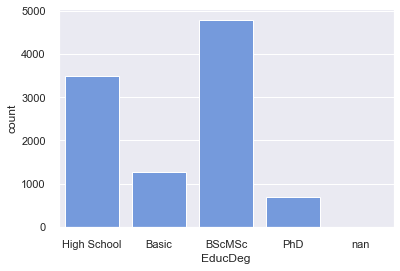

In [35]:
# Counting the genders in the dataset.

g=sns.countplot(data=ds, x="EducDeg", color="cornflowerblue")
plt.show();

We can see that most of the people in our dataset have either a Bsc or a Msc degree.

We need to get rid of the nans.

In [36]:
ds = ds[~ds['EducDeg'].isin([np.nan, 'nan'])]

In [37]:
ds['EducDeg'].unique()

array(['High School', 'Basic', 'BScMSc', 'PhD'], dtype=object)

In [38]:
ds.shape

(10248, 13)

### **The variable 'MonthSal':**

In [39]:
ds['MonthSal'].value_counts()

1398.0    10
3560.0    10
2687.0    10
3776.0    10
2073.0     9
          ..
1740.0     1
574.0      1
715.0      1
1198.0     1
3975.0     1
Name: MonthSal, Length: 3564, dtype: int64

In [40]:
ds = ds[~ds['MonthSal'].isin([np.nan, 'nan'])]

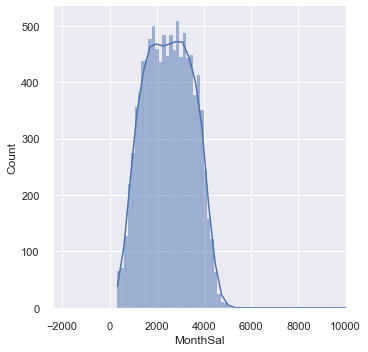

In [41]:
# Checking the histogram of the variable 'MonthSal'

g=sns.displot(data=ds, x="MonthSal", kde=True)
g.set(xlim=(None, 10_000))
plt.show();

We set an xlim value for the figure above because it used to shows the presence of outliers values that are very far from the true distribution of salaries.

In [42]:
ds.shape

(10215, 13)

### **The variable 'GeoLivArea':**

In [43]:
ds['GeoLivArea'].unique()

array([1., 4., 3., 2.])

In [44]:
ds['GeoLivArea'].value_counts()

4.0    4118
1.0    3021
3.0    2055
2.0    1021
Name: GeoLivArea, dtype: int64

We need to remove the nans values if they exist.

In [45]:
ds = ds[~ds['GeoLivArea'].isin([np.nan, 'nan'])]

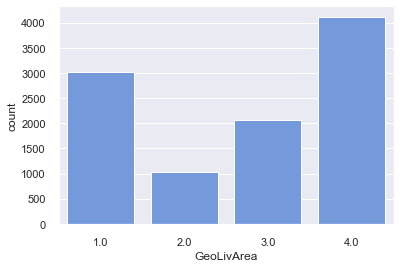

In [46]:
# Counting the 'GeoLivArea' in the dataset.

sns.countplot(data=ds, x="GeoLivArea", color="cornflowerblue")
plt.show();

As we can see most of the observations in our dataset live in the area 4.

In [47]:
ds.shape

(10215, 13)

### **The variable 'Children':**

In [48]:
ds['Children'].unique()

array([ 1.,  0., nan])

In [49]:
ds['Children'].value_counts()

1.0    7211
0.0    2991
Name: Children, dtype: int64

Again we need to get rid of the nans.

In [50]:
ds = ds[~ds['Children'].isin([np.nan, 'nan'])]

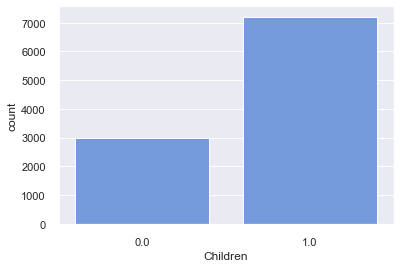

In [51]:
# Counting the 'Children' in the dataset.

sns.countplot(data=ds, x="Children", color="cornflowerblue")
plt.show()

We can see that most people in the dataset have children.

In [52]:
ds['Children'].unique()

array([1., 0.])

In [53]:
ds.shape

(10202, 13)

### The variable 'CustMonVal':

In [54]:
ds['CustMonVal'].isna().sum()

0

In [55]:
ds['CustMonVal'].unique()

array([ 380.97, -131.13,  504.67, ..., 1405.6 ,  524.1 ,  463.75])

In [56]:
ds = ds[~ds['CustMonVal'].isin([np.nan, 'nan'])]

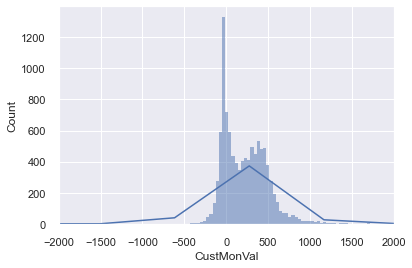

In [57]:
# Checking the histogram of the variable 'CustMonVal'

g=sns.histplot(data=ds, x="CustMonVal", kde=True)
g.set(xlim=(-2_000, 2_000))
plt.show();

We set an xlim value for the plot above because it used to show observations with very small negative values, they might be outliers we will decide how to deal with them in the next steps.

In [58]:
ds.shape

(10202, 13)

### **The variable 'ClaimsRate':**

In [59]:
ds['ClaimsRate'].isna().sum()

0

In [60]:
ds['ClaimsRate'].unique()

array([  0.39,   1.12,   0.28,   0.99,   0.9 ,   1.  ,   1.05,   1.13,
         0.36,   0.53,   0.46,   0.97,   1.06,   0.89,   0.85,   0.71,
         1.08,   0.64,   0.81,   0.41,   0.38,   0.5 ,   0.96,   0.19,
         0.69,   0.48,   0.94,   1.01,   0.98,   0.84,   0.47,   1.07,
         1.19,   0.63,   1.2 ,   0.32,  25.36,   1.14,   0.59,   0.13,
         0.66,   0.68,   0.61,   0.78,   0.33,   0.72,   0.2 ,   1.04,
         0.42,   0.95,   0.35,   1.03,   1.21,   0.4 ,   0.44,   0.77,
         0.93,   0.54,   0.25,   0.43,  15.65,   0.49,   0.14,   0.62,
         0.56,   0.57,   0.18,   0.91,   0.82,   0.12,  14.8 ,   0.65,
         0.31,   0.09,   0.22,   0.06,   0.3 ,   0.51,   0.26,   0.52,
         0.67,   0.58, 256.2 ,   0.29,   0.86,   0.6 ,   0.27,   0.79,
         0.88,   0.21,   0.24,   0.45,   0.23,   0.  ,   0.16,   0.07,
         0.75,   0.55,   0.08,   0.11,   0.37,   1.02,   1.3 ,   0.7 ,
         0.87,   1.1 ,   1.16,   0.92,   0.05,   0.83,   1.09,   1.25,
      

This variable does not contains any nans.
We will plot its histogram.

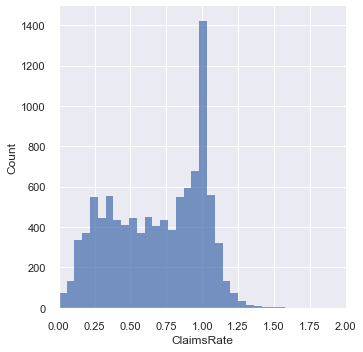

In [61]:
# Checking the histogram of the variable 'ClaimsRate'

g=sns.displot(data=ds, x="ClaimsRate", kde=False)
g.set(xlim=(0, 2))
plt.show()

We can see that the variable contains some outliers with claims Rate above 250. we set a value of xlim in order to obtain a more intersting plot.

In [62]:
ds.shape

(10202, 13)

### **The variable 'PremMotor':**

In [63]:
ds['PremMotor'].isna().sum()

31

In [64]:
ds['PremMotor'].unique()

array([375.85,  77.46, 206.15, ..., 105.13, 556.77,   6.89])

In [65]:
ds = ds[~ds['PremMotor'].isin([np.nan, 'nan'])]

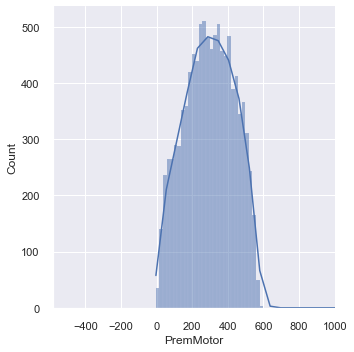

In [66]:
# Checking the histogram of the variable 'PremMotor'

g = sns.displot(data=ds, x="PremMotor", kde=True)
g.set(xlim=(None, 1000))
plt.show()

The variable seems to contains some outliers. the figure above have a value set to xlim.

In [67]:
ds.shape

(10171, 13)

### **The variable 'PremHousehold':**

In [68]:
ds['PremHousehold'].isna().sum()

0

In [69]:
ds['PremHousehold'].unique()

array([  79.45,  416.2 ,  224.5 , ..., 1070.2 , 1045.75, 1035.75])

In [70]:
ds = ds[~ds['PremHousehold'].isin([np.nan, 'nan'])]

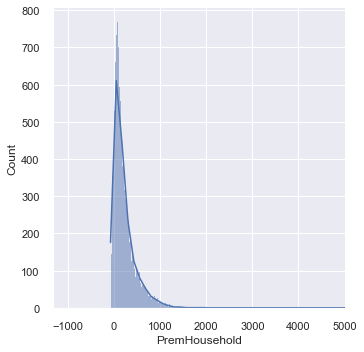

In [71]:
# Checking the histogram of the variable 'PremHousehold'

g=sns.displot(data=ds, x="PremHousehold", kde=True)
g.set(xlim=(None, 5_000))
plt.show();

The distribution is right skewed as it contains very big Household premiums values, we set a value for xlim in order to get a more visible histogram.

In [72]:
ds.shape

(10171, 13)

### **The variable 'Premhealth':**

In [73]:
ds['PremHealth'].isna().sum()

27

In [74]:
ds['PremHealth'].unique()

array([146.36, 116.69, 124.58, ..., 327.73, 390.74, 417.08])

In [75]:
ds['PremHealth'].value_counts()

130.47    30
178.70    29
159.14    27
169.70    26
147.36    26
          ..
316.95     1
374.96     1
298.28     1
354.29     1
417.08     1
Name: PremHealth, Length: 1006, dtype: int64

In [76]:
ds = ds[~ds['PremHealth'].isin([np.nan, 'nan'])]

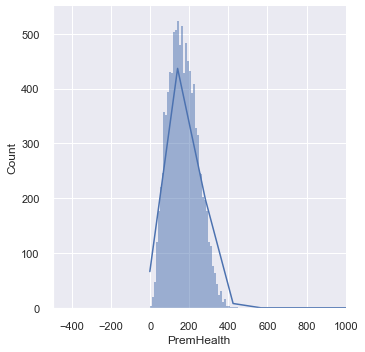

In [77]:
# Checking the histogram of the variable 'PremHealth'

g=sns.displot(data=ds, x="PremHealth", kde=True)
g.set(xlim=(-500, 1_000))
plt.show();

Right skewed distribution with very high values. The figure above does not show this issue as we set a value for xlim.

In [78]:
ds.shape

(10144, 13)

### **The variable 'PremLife':**

In [79]:
ds['PremLife'].isna().sum()

89

In [80]:
ds['PremLife'].unique()

array([ 47.01, 194.48,  86.35,  35.34,  18.78,   7.  ,  14.67,  66.68,
         8.78,  39.23,  18.67,  36.34,  43.12, 267.94,  10.89,  -3.  ,
       125.58,   3.89,  14.78,  24.45,  64.79,  48.01,  15.67,  17.56,
        -5.  ,  17.78,  -4.  ,  46.12,   4.78,  22.56,  40.23, 111.8 ,
        26.56,   3.  ,  53.01,  17.67, 146.36, 108.02,  52.01, 224.71,
       106.13,  59.79,  72.68,   1.89,  16.78,   5.  ,  12.78,  44.12,
        12.89,  -1.11,   6.  ,  69.68,  52.9 ,  30.34,  23.45,   6.89,
        16.56,  32.34,    nan,  20.56,  65.68,  70.79,  56.9 ,  51.12,
        22.67,  51.9 ,  48.12,  39.34,  29.56,   0.89,  30.56,   7.89,
        -6.  ,  38.23,  31.34,  32.45,  11.67,  31.45,  60.79,  -1.  ,
       185.48,  23.67,  67.68,  37.23,  19.56,  13.78,  12.67, 213.04,
         1.  ,  35.23,  29.34,   9.78,   2.89,   8.89,  29.45,  87.24,
        93.35,  11.89,   9.89,  71.79,  98.24,  37.34,  10.78,  21.56,
       136.47,  41.12, 104.02,  30.45,  73.57,  47.23, 131.47,  18.56,
      

In [81]:
ds = ds[~ds['PremLife'].isin([np.nan, 'nan'])]

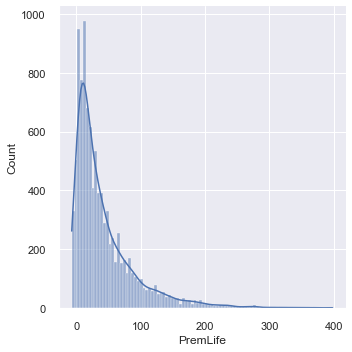

In [82]:
# Checking the histogram of the variable 'PremLife'

sns.displot(data=ds, x="PremLife", kde=True)
plt.show()

Right skewed distribution, but does not seem to contain outliers.

In [83]:
ds.shape

(10055, 13)

### **The variable 'PremWork':**

In [84]:
ds['PremWork'].isna().sum()

70

In [85]:
ds['PremWork'].unique()

array([  16.89,  106.13,   99.02,   28.34,   41.45,    7.67,   26.34,
         53.23,    9.89,   55.12,   10.89,   35.45,   15.78,   94.46,
         19.67,   37.23,   27.56,   72.57,   30.56,   33.34,   54.9 ,
         33.56,    4.78,   22.78,    9.78,   -0.11,   -5.  ,   -5.11,
          9.67,    7.89,   72.68,   65.79,   84.35,   40.23,    5.78,
        148.03,   25.34,   25.56,   23.34,   44.23,   75.79,   69.9 ,
         14.89,    3.89,   -9.  ,   30.45,    2.78,   10.  ,   62.68,
         16.78,   51.12,    8.78,   48.12,   -4.11,   -6.11,   97.35,
         17.89,   79.68,   33.23,   59.9 ,   20.78,    0.89,   29.67,
         73.68,   50.01,   -3.11,   30.23,   21.67,   17.78,    5.67,
         64.01,    8.67,   -1.  ,   12.67,   19.45,   29.56,   41.12,
         20.56,   -8.  ,  118.91,   59.68,   37.34,    6.89,  156.03,
        118.58,   28.45,   40.34,   14.67,  146.14,   16.56,   -1.11,
         99.35,  -12.  ,   60.9 ,   70.46,   26.56,   64.57,   41.23,
         68.68,   36

In [86]:
ds = ds[~ds['PremWork'].isin([np.nan, 'nan'])]

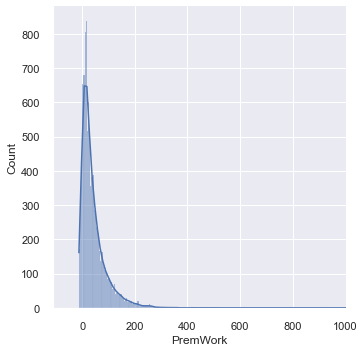

In [87]:
# Checking the histogram of the variable 'PremWork'

g = sns.displot(data=ds, x="PremWork", kde=True)
g.set(xlim=(None, 1_000))
plt.show();
## set limit here


Right skewed distribution. We set a value to xlim in order to get a visible histogram.

In [88]:
ds.shape

(9985, 13)

### Checking for missing values:

In [89]:
ds.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

We now have no missing data left.

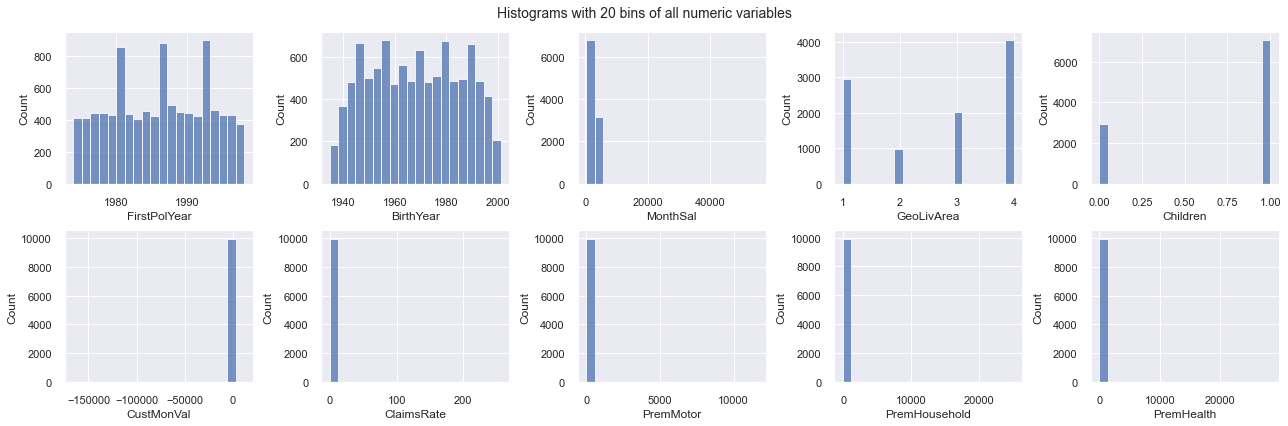

In [90]:
# HISTOGRAM (ALL NUMERIC VARIABLES)

# Identify all numeric variables in the dataset
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show();

The presence of outliers make the histograms not visible enough.

___

# **2. Features Engineering:**

### __Converting 'BirthYear' into 'Age':__

We convert the variable 'BirthYear' into 'Age'.

In [91]:
ds['Age'] = 2016 - ds['BirthYear']

In [92]:
ds.drop(columns=['BirthYear'], inplace=True)

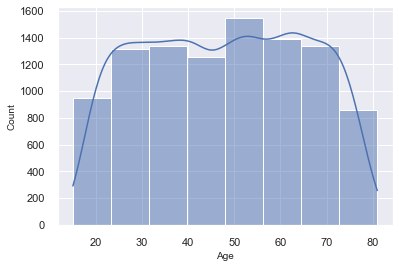

In [93]:
# Checking the histogram of the variable 'Age'.

sns.histplot(data=ds, x="Age", bins=8, kde=True)
plt.show()

The distribution of custumers ages is almost uniformly distributed.

### __Converting the variable 'FirstPolYear' into 'YearsAsCustomer':__

We convert the variable 'FirstPolYear' into 'YearsAsCustumer'

In [94]:
ds['YearsAsCustomer'] = 2016 - ds['FirstPolYear']

In [95]:
ds.drop(columns=['FirstPolYear'], inplace=True)

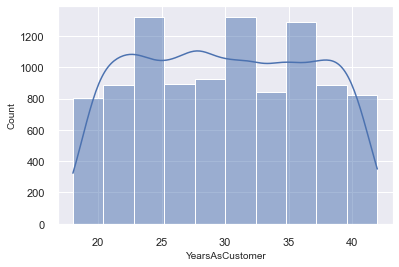

In [96]:
# Checking the histogram of the variable 'YearsAsCustumer'.

sns.histplot(data=ds, x="YearsAsCustomer", bins=10, kde=True)
plt.show()

In [97]:
ds.shape

(9985, 13)

___

# **3. Data Prepararion:**

In [98]:
X = ds.copy(deep=True)

In [99]:
X.shape

(9985, 13)

## __Encoding categorical variables:__

Encoding categorical variables to dummy variables.
For more information the different methods to enconde categorical variables
check https://contrib.scikit-learn.org/category_encoders/

In [100]:
cat_vars = ['EducDeg', 'GeoLivArea', 'Children']
ce_one_hot = ce.OneHotEncoder(cols = cat_vars, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [101]:
X.shape

(9985, 20)

## __Removing numerical outliers:__

In [102]:
num_vars = ["MonthSal", "CustMonVal", "ClaimsRate", "PremMotor", "PremHousehold", "PremHealth", 
            "PremLife", "PremWork"]

In [103]:
X[num_vars].describe().T

count         mean          std        min      25%      50%  \
MonthSal       9985.0  2505.675113  1164.237744     333.00  1700.00  2500.00   
CustMonVal     9985.0   177.798403  1975.430380 -165680.42    -8.22   187.82   
ClaimsRate     9985.0     0.745466     2.961024       0.00     0.40     0.72   
PremMotor      9985.0   298.926115   213.385202      -4.11   189.59   297.28   
PremHousehold  9985.0   213.013130   356.143193     -75.00    50.00   133.90   
PremHealth     9985.0   172.314024   300.084756      -2.11   112.02   163.03   
PremLife       9985.0    42.013345    47.627004      -7.00     9.89    25.56   
PremWork       9985.0    41.505458    51.737804     -12.00    10.67    26.34   

                   75%       max  
MonthSal       3293.00  55215.00  
CustMonVal      399.86  11875.89  
ClaimsRate        0.98    256.20  
PremMotor       406.30  11604.42  
PremHousehold   294.50  25048.80  
PremHealth      219.93  28272.00  
PremLife         57.90    398.30  
PremWork         56.79   1988.70

In [104]:
X_out, X_outliers = removeOutliers(X, num_vars, lowPercentile=0.02, highPercentile=0.95, verbose=True)

      MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0.02    717.68   -149.7252        0.11    37.9056         -45.55       39.34   
0.95   4046.00    648.4240        1.10   513.5400         696.80      297.50   

      PremLife  PremWork  
0.02     -4.32     -7.00  
0.95    140.47    137.58  


In [105]:
print(X_out.shape)
print(X_outliers.shape)

(6592, 20)
(258, 20)


In [106]:
X_out[num_vars].describe().T

count         mean         std     min      25%       50%  \
MonthSal       6592.0  2542.606493  842.526128  720.00  1844.00  2554.000   
CustMonVal     6592.0   206.057876  202.884695 -137.58     4.45   198.815   
ClaimsRate     6592.0     0.676635    0.287987    0.11     0.41     0.710   
PremMotor      6592.0   321.671778  106.354407   40.12   243.49   325.950   
PremHousehold  6592.0   164.330393  151.400037  -45.55    53.90   123.900   
PremHealth     6592.0   169.071945   61.700879   41.12   119.91   165.920   
PremLife       6592.0    33.062976   30.020330   -4.00    10.78    23.670   
PremWork       6592.0    32.602935   29.924974   -7.00    10.89    23.670   

                     75%      max  
MonthSal       3245.0000  4046.00  
CustMonVal      383.3025   647.89  
ClaimsRate        0.9600     1.10  
PremMotor       407.4100   513.54  
PremHousehold   240.6000   696.80  
PremHealth      216.9300   297.50  
PremLife         47.2300   140.47  
PremWork         47.3400   137.58

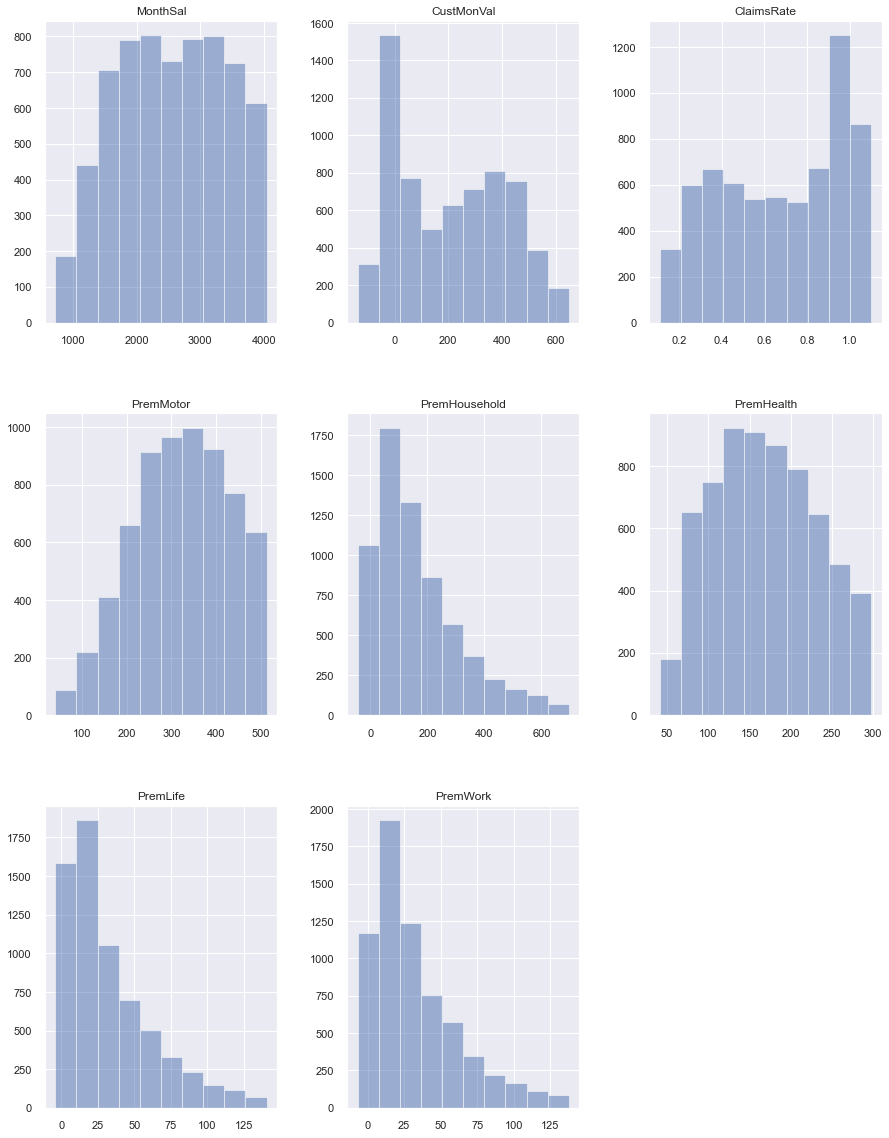

In [107]:
X_out[num_vars].hist(color='b', alpha=0.5, bins=10, figsize = (15,20))
plt.show()

In [108]:
X = X_out.copy(deep=True)

## __Scaling the numerical variables:__

Get a copy of the dataframe before normalization for results' analysis.

In [109]:
X_beforeNorm = X.copy(deep=True)

In [110]:
num_vars += ['Age', 'YearsAsCustomer'] 

In [111]:
# Normalize all columns
# StandardScaler returns an array, so the dataframe must be recreated
X[num_vars] = pd.DataFrame(StandardScaler().fit_transform(X[num_vars].values), 
                           columns=num_vars,index=X.index)

In [112]:
# Check dataframe structure and statistics after all transformations
print(X.shape)
X[num_vars].describe().T

(6592, 20)


count          mean       std       min       25%       50%  \
MonthSal         6592.0 -9.279928e-18  1.000076 -2.163428 -0.829244  0.013524   
CustMonVal       6592.0 -1.505673e-17  1.000076 -1.693888 -0.993782 -0.035702   
ClaimsRate       6592.0 -2.034511e-17  1.000076 -1.967724 -0.925930  0.115864   
PremMotor        6592.0 -3.325785e-16  1.000076 -2.647499 -0.735162  0.040229   
PremHousehold    6592.0 -1.654387e-16  1.000076 -1.386369 -0.729450 -0.267064   
PremHealth       6592.0 -2.422297e-16  1.000076 -2.073903 -0.796839 -0.051088   
PremLife         6592.0 -8.449619e-17  1.000076 -1.234690 -0.742319 -0.312911   
PremWork         6592.0  1.857670e-16  1.000076 -1.323508 -0.725634 -0.298534   
Age              6592.0  2.275688e-16  1.000076 -2.196639 -0.841777 -0.003054   
YearsAsCustomer  6592.0 -5.896376e-17  1.000076 -1.814780 -0.904421  0.005938   

                      75%       max  
MonthSal         0.833739  1.784523  
CustMonVal       0.873689  2.177915  
ClaimsRate       0.984025  1.470196  
PremMotor        0.806217  1.804183  
PremHousehold    0.503800  3.517238  
PremHealth       0.775705  2.081620  
PremLife         0.471950  3.578081  
PremWork         0.492504  3.508275  
Age              0.835670  2.061497  
YearsAsCustomer  0.916298  1.826657

- The results transformation made the modeling dataset end up with 20 columns.
- All columns are now numeric, with values in the range of -3 to 3.

___

# **4. Analyze Principal Components:**

Visualizing the PCA with only two components.

(6592, 2)


locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B3C57DF0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B3C57DF0> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


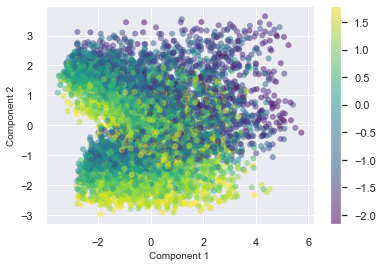

In [113]:
pca2 = PCA(n_components = 2, random_state=random_state)
pca2.fit(X[num_vars])
X_pca2 = pca2.transform(X[num_vars])
print(X_pca2.shape)

# Scatter plot of the two Principal Components by the "target" to see if there is any pattern
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=X["MonthSal"], edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show();

- The plot above does not show any clusters.

In [114]:
# Fit the PCA algorithm to the dataset. 
pca = PCA().fit(X)

# Output PCA table
pcaDF=pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": 100*np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

pcaDF

Eigenvalue    Difference    Proportion  Cumulative
1   3.023783e+00  0.000000e+00  2.586387e-01   25.863873
2   2.053124e+00 -9.706590e-01  1.756136e-01   43.425230
3   1.918994e+00 -1.341300e-01  1.641408e-01   59.839309
4   1.000050e+00 -9.189432e-01  8.553914e-02   68.393224
5   9.030771e-01 -9.697337e-02  7.724454e-02   76.117678
6   6.054228e-01 -2.976543e-01  5.178474e-02   81.296151
7   5.860665e-01 -1.935632e-02  5.012910e-02   86.309061
8   3.730308e-01 -2.130357e-01  3.190713e-02   89.499774
9   3.485467e-01 -2.448417e-02  2.981288e-02   92.481062
10  2.315870e-01 -1.169596e-01  1.980876e-02   94.461937
11  2.278432e-01 -3.743815e-03  1.948853e-02   96.410790
12  1.239260e-01 -1.039172e-01  1.059999e-02   97.470789
13  1.151434e-01 -8.782543e-03  9.848774e-03   98.455666
14  8.935596e-02 -2.578747e-02  7.643047e-03   99.219971
15  6.556130e-02 -2.379466e-02  5.607775e-03   99.780749
16  1.530718e-02 -5.025412e-02  1.309297e-03   99.911678
17  1.032581e-02 -4.981368e-03  8.832167e-04  100.000000
18  2.896167e-31 -1.032581e-02  2.477232e-32  100.000000
19  1.655215e-32 -2.730646e-31  1.415786e-33  100.000000
20  7.730275e-34 -1.577913e-32  6.612078e-35  100.000000

- From the above we can see that two components only explain 42.22% of the variance, meaning its not enough to select the number of clusters using the plot above.

No handles with labels found to put in legend.


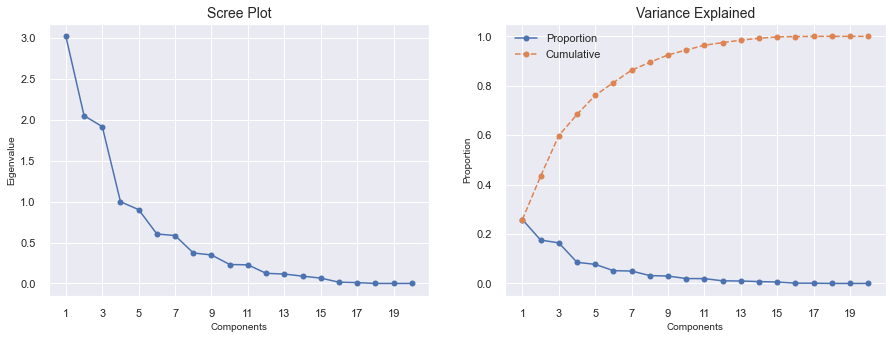

In [115]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax1.legend()
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show();

In [116]:
np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9)

8

- checking the number of components that have an acumulated variance bigger that 90%.

___

# **5. KMeans:**

### *Characteristics:*
- *Number of clusters* need to be set apriori.
- One of the *fastest* clustering algorithms.
- The results *depend on the initialization* (stochastic).
- Prone to *local optima*.
- Favors *convex* (round shape) and *isotropic* (same shape) clusters.

## __Defining the number of clusters.__

In [117]:
range_clusters = range(1, 11)

In [118]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=random_state)
    kmclust.fit(X[num_vars])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

**Inertia (within-cluster sum-of-squares distance) Formula:**
$$\sum_{j=0}^{C}\sum_{i=0}^{n_j}(||x_i - \mu_j||^2)$$
, where:

$C$: Set of identified clusters.

$n_j$: Set of observations belonging to cluster $j$.

$x_i$: Observation $i$.

$\mu_j$: Centroid of cluster $j$.

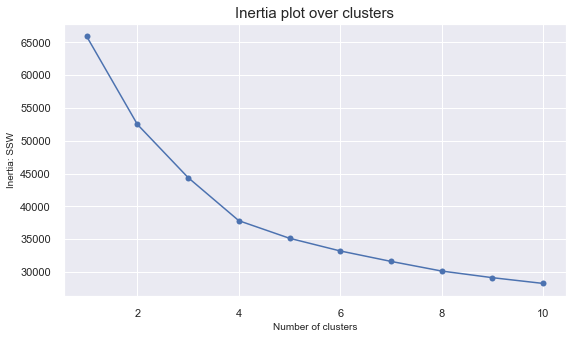

In [119]:
# The inertia plot.
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia, marker=".", markersize=12)
plt.ylabel("Inertia: SSW")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show();

- The plot above shows that the optimal number of clusters is equal to 3.

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

For n_clusters = 2, the average silhouette_score is : 0.19415434064752862
For n_clusters = 3, the average silhouette_score is : 0.19120217231644385
For n_clusters = 4, the average silhouette_score is : 0.21819411776095873
For n_clusters = 5, the average silhouette_score is : 0.20265932283860952
For n_clusters = 6, the average silhouette_score is : 0.1893497011778345
For n_clusters = 7, the average silhouette_score is : 0.17650210551649834
For n_clusters = 8, the average silhouette_score is : 0.16808454213966487
For n_clusters = 9, the average silhouette_score is : 0.1513947696172698
For n_clusters = 10, the average silhouette_score is : 0.14801940209751435


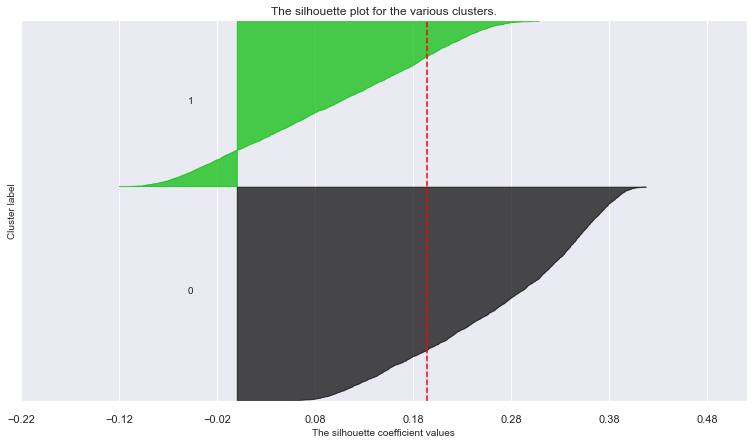

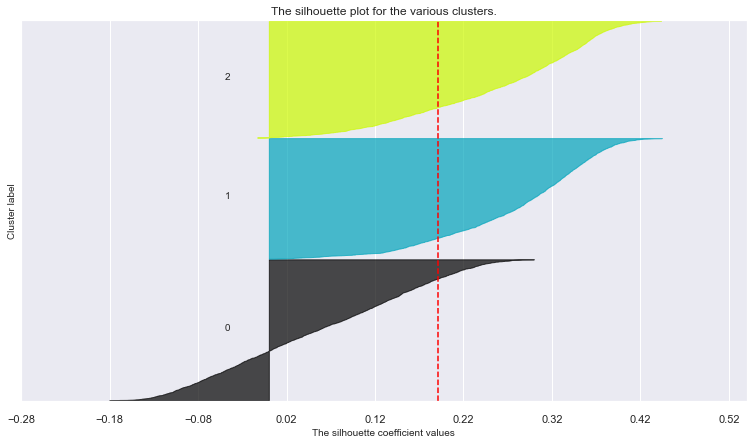

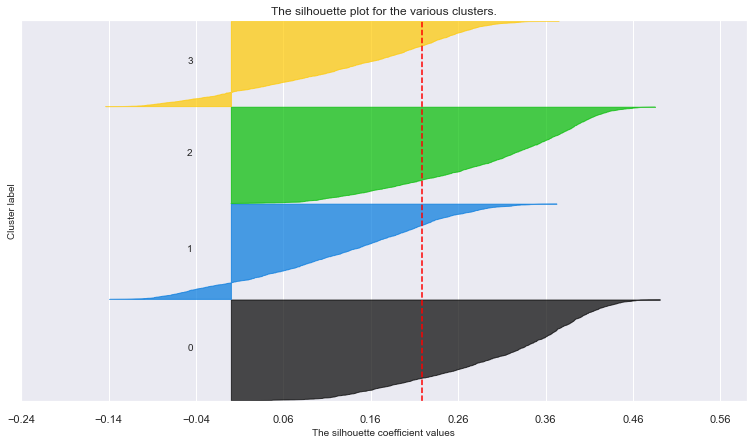

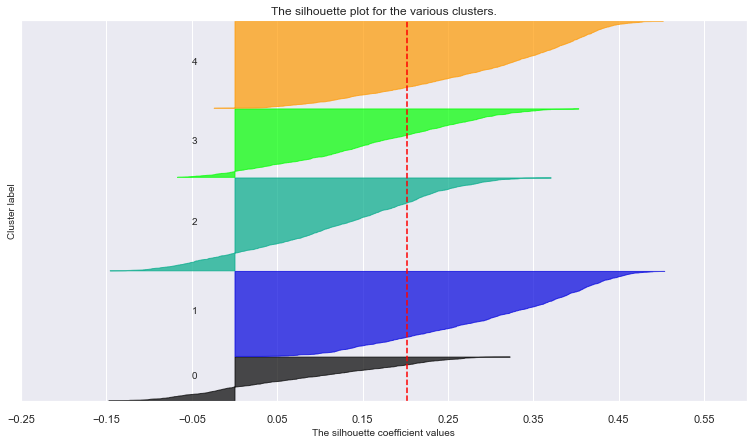

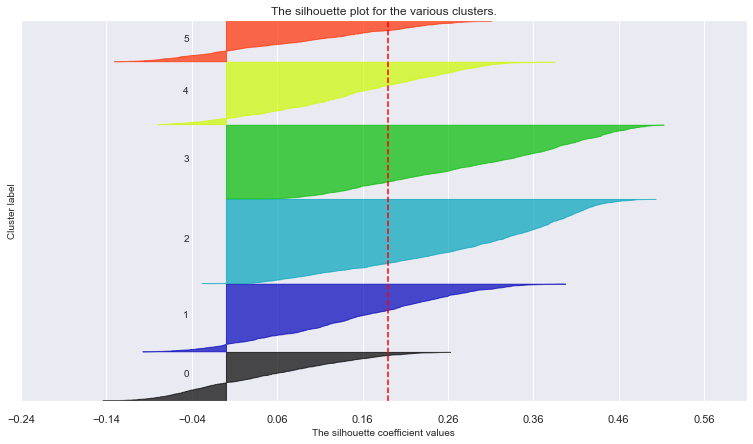

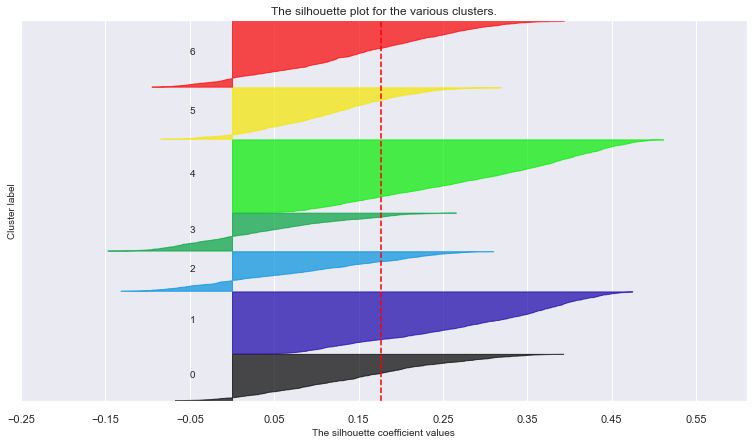

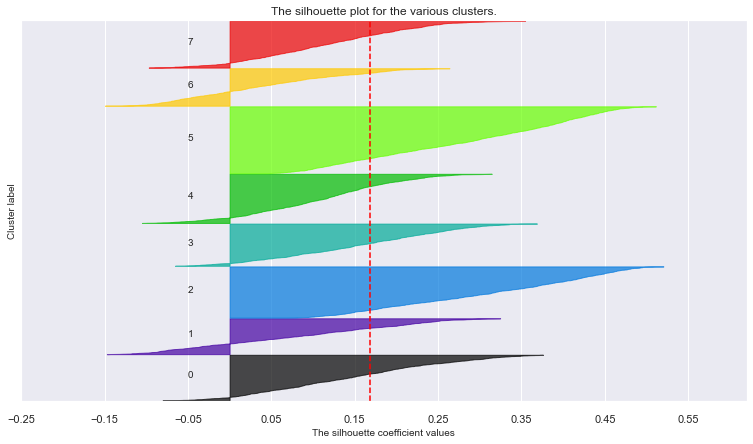

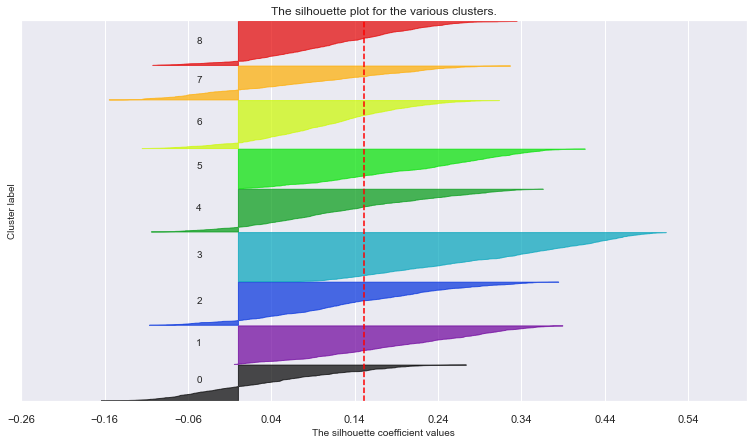

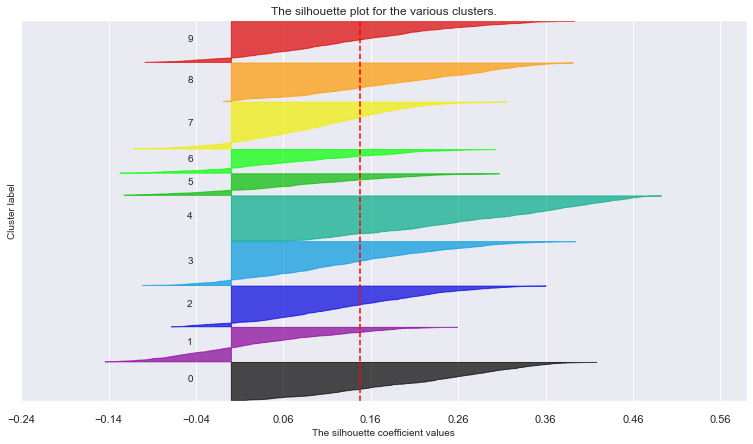

In [120]:
# Calclating the silhouette score.

avg_silhouette = get_avg_silhouette(X[num_vars], KMeans(init='k-means++', n_init=20, random_state=random_state))

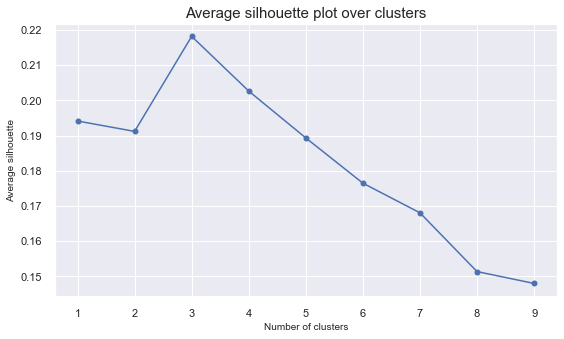

In [121]:
# The average silhouette plot
plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette, marker=".", markersize=12)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

- The plot above shows that the optimal number of clusters is equal to 3, which matches the results obtained using the elbow method.

#### **Using Sklearn:**

In [122]:
# final clusters solution:

number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=20, random_state=random_state)
allDistances = kmclust.fit_transform(X[num_vars])
km_labels = kmclust.fit_predict(X[num_vars])

- *init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization.  

- *n_init=n* allows to initialize KMeans n times and pick the best clustering in terms of Inertia. 

In [123]:
# Characterizing the final clusters:
X_kmeans = pd.concat((X, pd.Series(km_labels, index=X.index, name='km_labels')), axis=1)

In [124]:
# Characterizing the final clusters:
X_beforeNorm_kmeans = pd.concat((X_beforeNorm, pd.Series(km_labels, index=X_beforeNorm.index,
                                                         name='km_labels')), axis=1)
X_beforeNorm_kmeans.groupby('km_labels').mean().T

km_labels                      0            1            2
EducDeg_High School     0.464794     0.276403     0.259715
EducDeg_Basic           0.128205     0.045671     0.050664
EducDeg_BScMSc          0.382173     0.580400     0.598623
EducDeg_PhD             0.024827     0.097526     0.090999
MonthSal             2408.623932  2653.060894  2590.329070
GeoLivArea_1.0          0.295889     0.284015     0.311363
GeoLivArea_4.0          0.412698     0.406755     0.400885
GeoLivArea_3.0          0.195767     0.202664     0.198229
GeoLivArea_2.0          0.095645     0.106565     0.089523
Children_1.0            0.661376     0.781637     0.801771
Children_0.0            0.338624     0.218363     0.198229
CustMonVal            205.005116     8.653321   411.434663
ClaimsRate              0.715726     0.951813     0.344875
PremMotor             212.166984   386.589110   386.894132
PremHousehold         275.645381    93.739510   102.786424
PremHealth            211.082320   145.721327   142.443074
PremLife               55.910981    18.939520    20.052627
PremWork               55.128799    19.012008    19.431308
Age                    46.618234    51.144624    49.814560
YearsAsCustomer        29.681726    30.086584    30.168224

**Plotting clusters cardinality, magnitude, and cardinality vs magnitude:** 

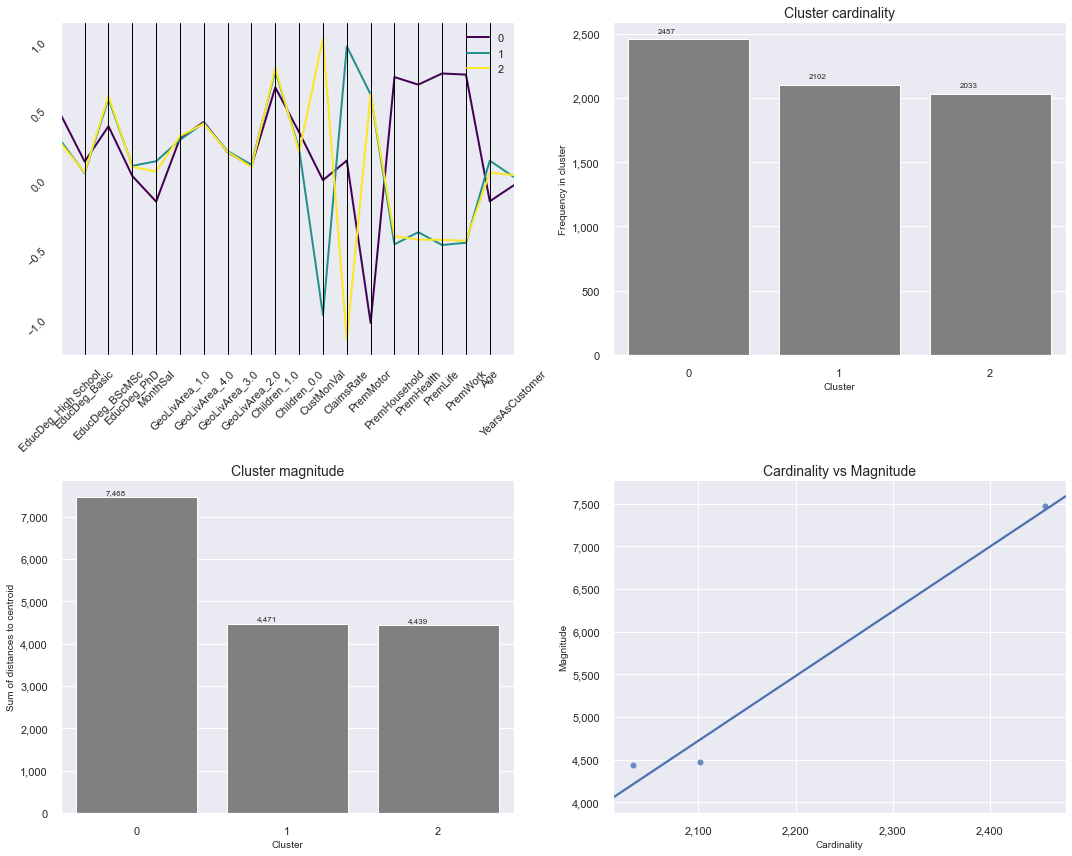

In [125]:
get_cluster_analysis(X_kmeans, "km_labels", allDistances)

**Visualizing the clusters sizes and distances in 2D:**

top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


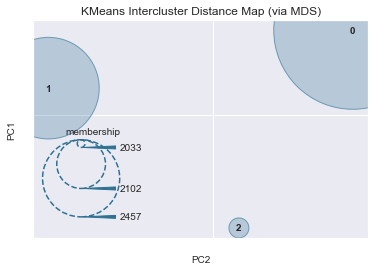

In [126]:
visualizer = InterclusterDistance(kmclust)
visualizer.fit(X[num_vars])
visualizer.show()
plt.show()

#### **Using Scipy:**

In [127]:
# computing K-Means with K clusters.

codebook, distortion = kmeans(X[num_vars], k_or_guess=number_clusters, iter=20)

- **codebook:** A k by N array of k centroids. The ith centroid codebook[i] is represented with the code i. The centroids and codes generated represent the lowest distortion seen, not necessarily the globally minimal distortion. Note that the number of centroids is not necessarily the same as the k_or_guess parameter, because centroids assigned to no observations are removed during iterations.

- **distortion:** The mean (non-squared) Euclidean distance between the observations passed and the centroids generated. Note the difference to the standard definition of distortion in the context of the k-means algorithm, which is the sum of the squared distances.

In [128]:
# assign each sample to a cluster
code, dist = vq(X[num_vars], codebook)

- **code:** A length M array holding the code book index for each observation.

- **dist:** The distortion (distance) between the observation and its nearest code.

In [129]:
# Characterizing the final clusters:
X_kmeans = pd.concat((X, pd.Series(code, index=X.index, name='km_labels')), axis=1)

In [130]:
# Characterizing the final clusters:
X_beforeNorm_kmeans = pd.concat((X_beforeNorm, pd.Series(code, index=X_beforeNorm.index,
                                                         name='km_labels')), axis=1)
X_beforeNorm_kmeans.groupby('km_labels').mean().T

km_labels                      0            1            2
EducDeg_High School     0.274576     0.258847     0.459788
EducDeg_Basic           0.045521     0.051062     0.125147
EducDeg_BScMSc          0.581598     0.597573     0.389565
EducDeg_PhD             0.098305     0.092518     0.025500
MonthSal             2648.287167  2582.264408  2426.218125
GeoLivArea_1.0          0.283777     0.310415     0.296979
GeoLivArea_4.0          0.406780     0.398382     0.414280
GeoLivArea_3.0          0.203390     0.199697     0.194194
GeoLivArea_2.0          0.106053     0.091507     0.094547
Children_1.0            0.784019     0.807887     0.659474
Children_0.0            0.215981     0.192113     0.340526
CustMonVal              7.526315   413.708933   205.757321
ClaimsRate              0.953419     0.339965     0.713660
PremMotor             388.390412   389.841739   214.722322
PremHousehold          92.553099   100.405359   272.083954
PremHealth            144.748964   140.500622   210.947595
PremLife               18.617893    19.853964    55.015320
PremWork               18.672421    19.176380    54.307226
Age                    51.100726    49.689585    46.885445
YearsAsCustomer        30.059080    30.186047    29.706552

__Clusters Profiling:__

- __cluster 1__: 
    - The mean of ages is equal to 46.
    - The second highest value of customer monetary value.
    - The second highest claims rate value.
    - The highest values of premiums for work, life, health, and household. 
    - The lowest value of motor premium. 
    - The majority of observations have a high school degree.
- __cluster 2__: 
    - The mean of ages is equal to 51.
    - The highest claims rate value.
    - The lowest customer monetary value.
    - The highest average salary.
    - The majority of observations have either a Bsc or Msc degree.
    - The majority of observations have children.
- __cluster 3__: 
    - The mean of ages is equal to 49.
    - The lowest claims rate.
    - The highest customer monetary value.
    - the second highest average monthly salary.
    - The highest value of motor premium.
    - The majority of observations have either a Bsc or a Msc degree.

**Clusters R²:**

In [131]:
r2_kmm =  get_r2(X_kmeans, "km_labels")
print("Cluster solution with R² of %0.4f" % r2_kmm);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_kmeans[num_vars + ['km_labels']], 'km_labels').drop('km_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R² of 0.3222


ClaimsRate         0.705945
PremMotor          0.637672
CustMonVal         0.614379
PremLife           0.337441
PremWork           0.331751
PremHousehold      0.319818
PremHealth         0.291177
Age                0.013536
MonthSal           0.012975
YearsAsCustomer    0.000996
dtype: float64

The R² of this clusters solution is not very high, the variables that contribute the most to the R² value are 'ClaimsRate' and 'PremMotor'.

## __Visualization of KMeans clusters using Tsne:__

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B3BDC2E0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B3BDC2E0> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


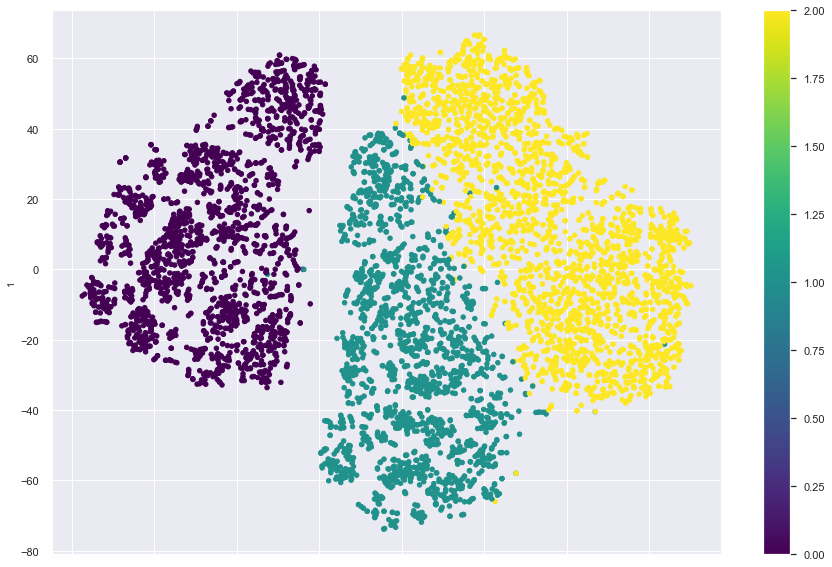

In [132]:
Tsne_km = TSNE(perplexity=30, random_state=random_state).fit_transform(X_kmeans)
pd.DataFrame(Tsne_km).plot.scatter(x=0, y=1, c = X_kmeans['km_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

- As we can see the obtained clusters are well separated which is a good thing.

---

# **6. Hierarchical Clustering:**

### Different types of linkage

![Comparing different hierarchical linkage methods](https://scikit-learn.org/stable/_images/sphx_glr_plot_linkage_comparison_001.png)

### Characteristics:
- *bottom up approach*: each observation starts in its own cluster, and clusters are successively merged together.
- *greedy/local algorithm*: at each iteration tries to minimize the distance of cluster merging.
- *no realocation*: after an observation is assigned to a cluster, it can no longer change.
- *deterministic*: you always get the same answer when you run it.
- *scalability*: can be *very slow* for a large number of observations.

### __Defining the linkage method to choose:__

**We know that:**
$$SS_{t} = SS_{w} + SS_{b}$$

---

$$SS_{t} = \sum\limits_{i = 1}^n {{{({x_i} - \overline x )}^2}}$$

$$SS_{w} = \sum\limits_{k = 1}^K {\sum\limits_{i = 1}^{{n_k}} {{{({x_i} - {{\overline x }_k})}^2}} }$$

$$SS_{b} = \sum\limits_{k = 1}^K {{n_k}{{({{\overline x }_k} - \overline x )}^2}}$$

, where $n$ is the total number of observations, $x_i$ is the vector of the $i^{th}$ observation, $\overline x$ is the centroid of the data, $K$  is the number of clusters, $n_k$ is the number of observations in the $k^{th}$ cluster and $\overline x_k$ is the centroid of the $k^{th}$ cluster.

In [133]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical
    method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt or
    R2 = 1 - SSw/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering.
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods.
    min_nclus (int): minimum number of clusters to compare the methods. Defaults value is 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. 
    Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """    
    def get_ss(df):
        """Computes the sum of squares for all variables given a dataset
        """
        ss = np.sum(df.var()*(df.count() - 1))
        return ss  # return sum of sum of squares of each df variable.
    
    sst = get_ss(df)  # get total sum of squares.
    
    r2 = []  # To store the R2 metrics for each cluster solution.
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, index = df.index,
                                             name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb/sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

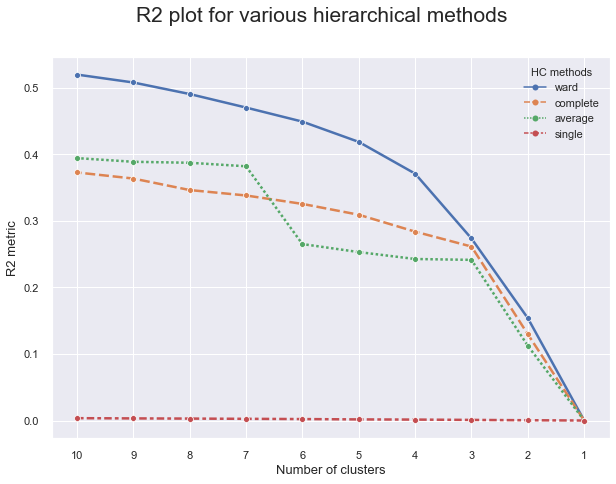

In [134]:
# Preparing the inputs.
hc_methods = ["ward", "complete", "average", "single"]
# Calling the function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=X[num_vars], link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plotting the data:
fig = plt.figure(figsize=(10,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis.
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

- We can see that _ward linkage_ provides the best results.

**Ward linkage**: minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

### __Defining the number of clusters:__
Where is the **first big jump** on the Dendrogram?

Inspired from: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

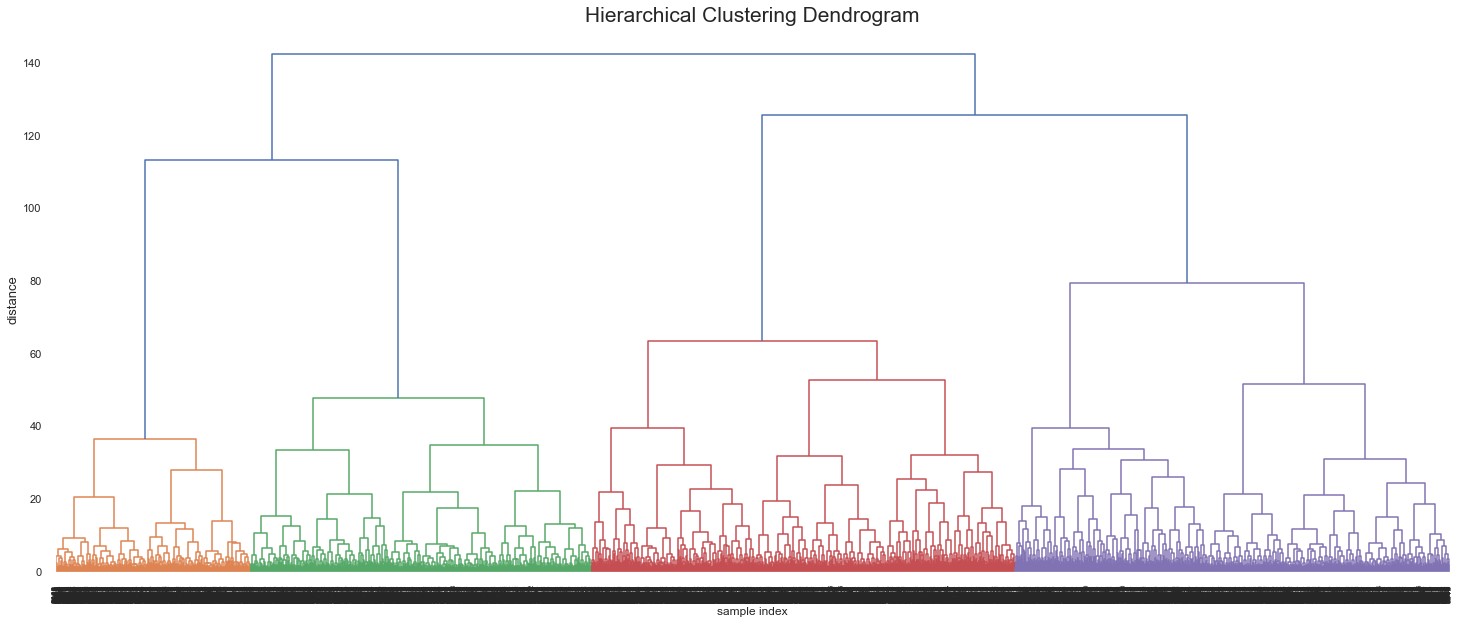

In [135]:
linked = linkage(X[num_vars], method="ward", metric="euclidean")

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('sample index')
plt.ylabel('distance', fontsize=13)
dendrogram(
    linked,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [136]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

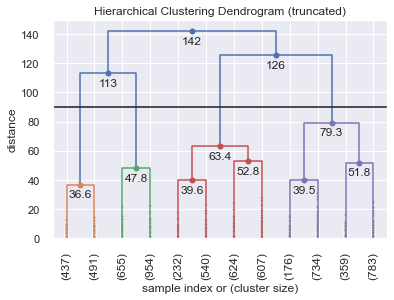

In [137]:
max_d = 90

fancy_dendrogram(
    linked,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.13126771457707204
For n_clusters = 3, the average silhouette_score is : 0.15300700893834818
For n_clusters = 4, the average silhouette_score is : 0.1641221869149258
For n_clusters = 5, the average silhouette_score is : 0.15426566174971681
For n_clusters = 6, the average silhouette_score is : 0.14832495804523643
For n_clusters = 7, the average silhouette_score is : 0.1392266143090339
For n_clusters = 8, the average silhouette_score is : 0.12015680862650067
For n_clusters = 9, the average silhouette_score is : 0.10365857138049434
For n_clusters = 10, the average silhouette_score is : 0.10127152039824416


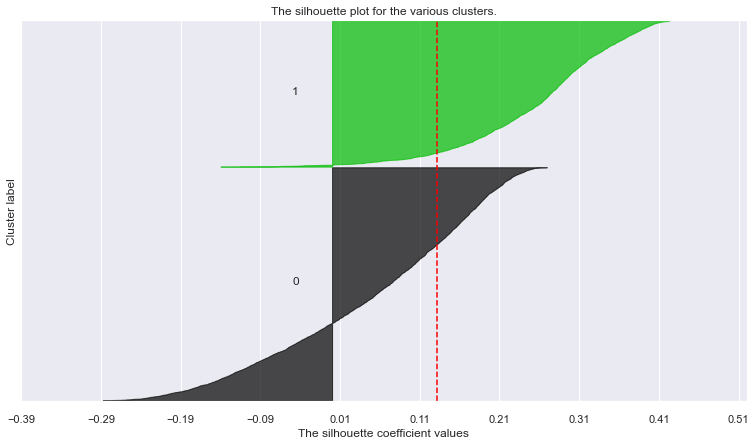

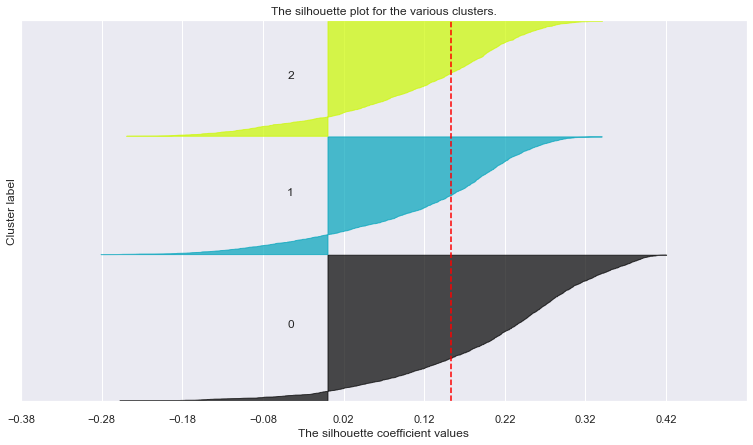

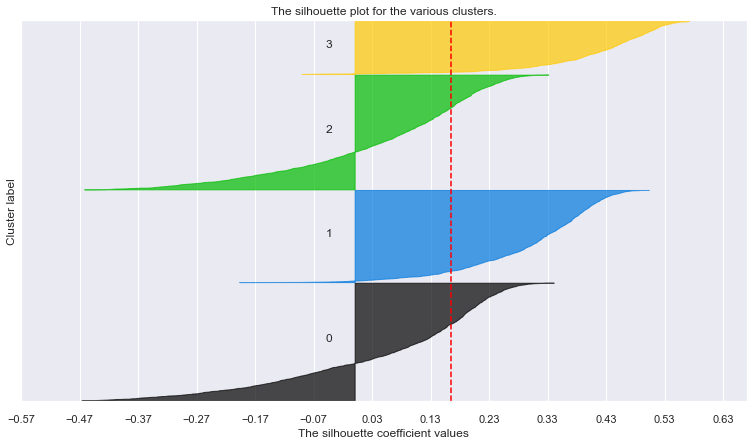

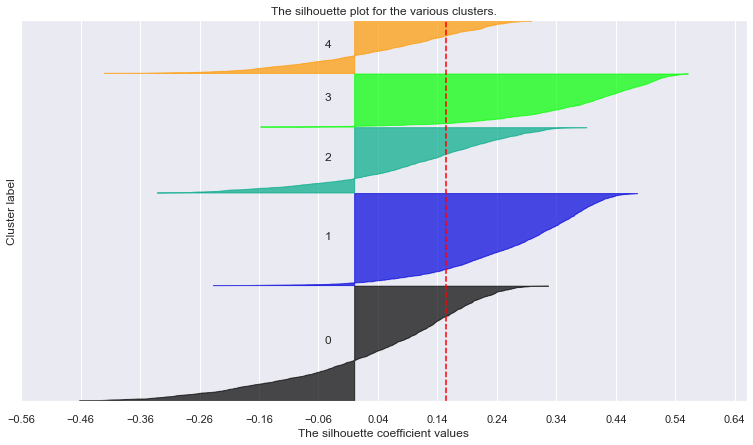

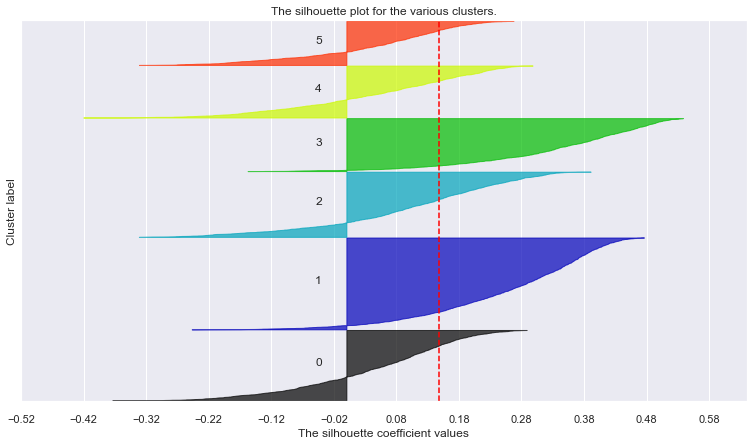

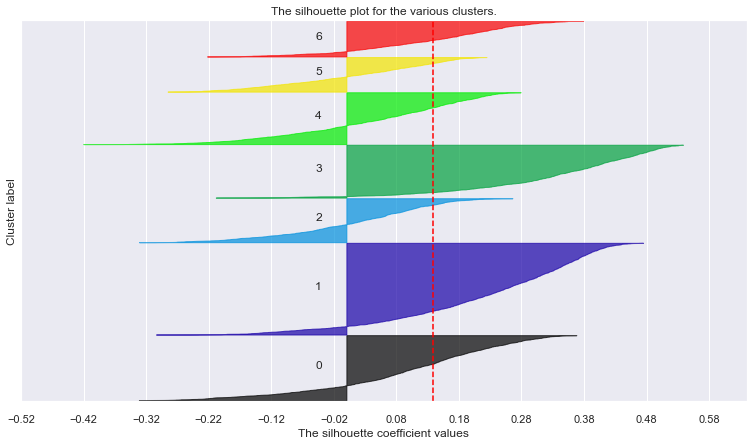

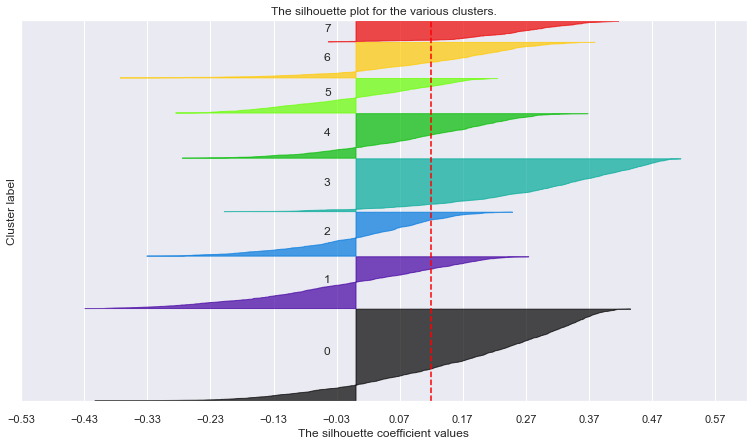

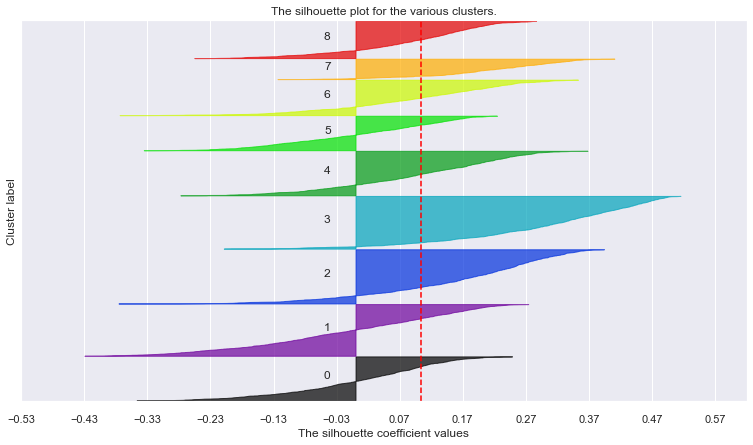

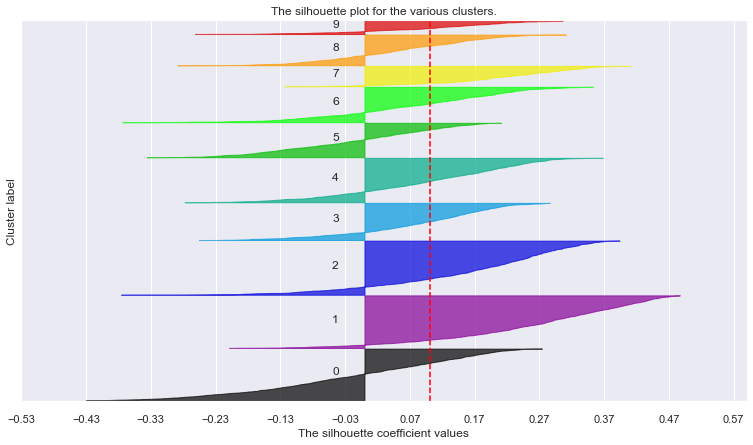

In [138]:
# Getting the silhouette score.

avg_silhouette_hc=get_avg_silhouette(X[num_vars], AgglomerativeClustering(linkage="ward", 
                                                                          affinity="euclidean"))

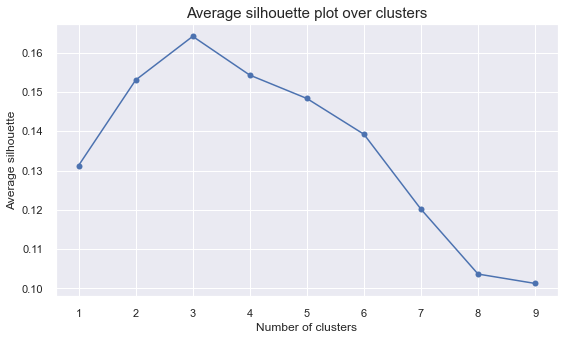

In [139]:
# The average silhouette plot
plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette_hc, marker=".", markersize=12)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

The silhouette plot shows that the best number of clusters to choose is 3, but the dendrogram above shows that the best number of clusters to consider is equal to 4.

### __Final Hierarchical clustering solution:__

#### __Using sklearn:__

In [140]:
# 4 cluster solution:
link = 'ward'
distance = 'euclidean'
n_clusters=4
hcclust = AgglomerativeClustering(linkage=link, affinity=distance, 
                                  n_clusters=n_clusters, compute_distances=True)
hc_labels = hcclust.fit_predict(X[num_vars])

In [141]:
# Characterizing the clusters
X_hc = pd.concat((X, pd.Series(hc_labels, index=X.index, name='hc_labels')), axis=1)

**We verify the relation bellow for each variable in our dataframe:**
$$SS_{t} = SS_{w} + SS_{b}$$

In [142]:
# Computing SST
X_tmp = X_hc[num_vars+["hc_labels"]].values
sst = np.sum(np.square(X_tmp - X_tmp.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X_tmp[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X_tmp[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X_tmp.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [143]:
# Characterizing the clusters.
X_beforeNorm_hc = pd.concat((X_beforeNorm, pd.Series(hc_labels, index=X_beforeNorm.index, name='hc_labels')), axis=1)
X_beforeNorm_hc.groupby('hc_labels').mean().T

hc_labels                      0            1            2            3
EducDeg_High School     0.379630     0.283406     0.389915     0.253233
EducDeg_Basic           0.106238     0.045991     0.094358     0.035560
EducDeg_BScMSc          0.466374     0.568055     0.471792     0.603448
EducDeg_PhD             0.047758     0.102548     0.043934     0.107759
MonthSal             1678.337719  2704.270354  3304.291563  2529.359914
GeoLivArea_1.0          0.308480     0.282163     0.289566     0.312500
GeoLivArea_4.0          0.393762     0.416408     0.421867     0.389009
GeoLivArea_3.0          0.203216     0.194531     0.197703     0.198276
GeoLivArea_2.0          0.094542     0.106899     0.090864     0.100216
Children_1.0            0.914230     0.804848     0.455816     0.877155
Children_0.0            0.085770     0.195152     0.544184     0.122845
CustMonVal            218.299035     2.561293   247.314204   442.772015
ClaimsRate              0.676852     0.960354     0.638238     0.267112
PremMotor             254.071394   407.919416   266.771318   440.108373
PremHousehold         216.845980    90.914295   215.636445    64.759806
PremHealth            206.091769   128.202368   192.126096   108.314407
PremLife               43.097890    16.961504    44.436955    14.241369
PremWork               42.425146    18.059086    42.876875    13.925323
Age                    32.593567    52.223120    63.431353    48.877155
YearsAsCustomer        30.335283    30.259167    30.026960    28.473060

#### __Using Scipy:__

In [144]:
k=4
hc_labels = fcluster(linked, k, criterion='maxclust')

In [145]:
# Characterizing the clusters
X_hc = pd.concat((X, pd.Series(hc_labels, index=X.index, name='hc_labels')), axis=1)

In [146]:
# Characterizing the clusters.
X_beforeNorm_hc = pd.concat((X_beforeNorm, pd.Series(hc_labels, index=X_beforeNorm.index, name='hc_labels')), axis=1)
X_beforeNorm_hc.groupby('hc_labels').mean().T

hc_labels                      1            2            3            4
EducDeg_High School     0.253233     0.283406     0.389915     0.379630
EducDeg_Basic           0.035560     0.045991     0.094358     0.106238
EducDeg_BScMSc          0.603448     0.568055     0.471792     0.466374
EducDeg_PhD             0.107759     0.102548     0.043934     0.047758
MonthSal             2529.359914  2704.270354  3304.291563  1678.337719
GeoLivArea_1.0          0.312500     0.282163     0.289566     0.308480
GeoLivArea_4.0          0.389009     0.416408     0.421867     0.393762
GeoLivArea_3.0          0.198276     0.194531     0.197703     0.203216
GeoLivArea_2.0          0.100216     0.106899     0.090864     0.094542
Children_1.0            0.877155     0.804848     0.455816     0.914230
Children_0.0            0.122845     0.195152     0.544184     0.085770
CustMonVal            442.772015     2.561293   247.314204   218.299035
ClaimsRate              0.267112     0.960354     0.638238     0.676852
PremMotor             440.108373   407.919416   266.771318   254.071394
PremHousehold          64.759806    90.914295   215.636445   216.845980
PremHealth            108.314407   128.202368   192.126096   206.091769
PremLife               14.241369    16.961504    44.436955    43.097890
PremWork               13.925323    18.059086    42.876875    42.425146
Age                    48.877155    52.223120    63.431353    32.593567
YearsAsCustomer        28.473060    30.259167    30.026960    30.335283

__Clusters Profiling:__

- __cluster 1__: 
    - The mean of ages is equal to 49.
    - The lowest claims rate.
    - The highest customer monetary value.
    - The third highest monthly salary.
    - The majority of observations have either a Bsc or Msc degree.
- __cluster 2__: 
    - The mean of ages is equal to 52.
    - The highest claims rate. 
    - The lowest customer monetary value.
    - The second highest value of motor premium.
- __cluster 3__:
    - The oldest group of observations with a mean of ages equal to 63.
    - A relatively high claims rate.
    - A relatively high customer monetary value.
    - The highest monthly salary.
- __cluster 4__:
    - The youngest group of observation with a mean of ages equal to 30.
    - The lowest monthly salary.
    - A relatively high claims rate.
    - A relatively high customer monetary value.

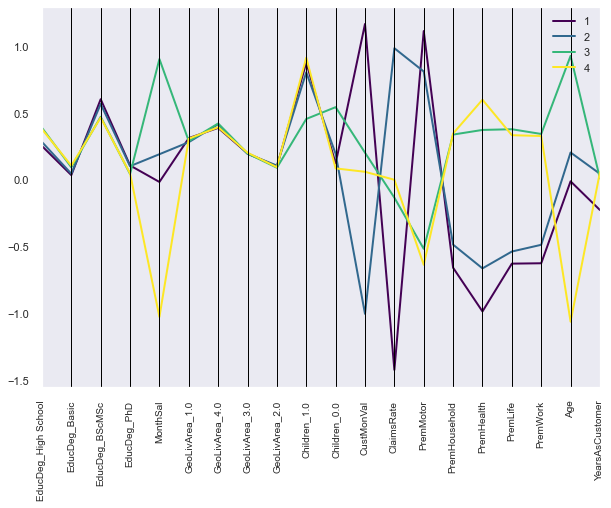

In [147]:
plt.figure(figsize=(10, 7))

# We need to define the centroids of our clusters.
centroids = X_hc.groupby('hc_labels', as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, class_column = "hc_labels", colormap="viridis",lw=2)

plt.xticks(fontsize=10, rotation=90)
plt.show()

**Clusters R²:**

In [148]:
r2_hc =  get_r2(X_hc, "hc_labels")
print("Cluster solution with R^2 of %0.4f" % r2_hc);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_hc[num_vars + ['hc_labels']], 'hc_labels').drop('hc_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.3814


Age                0.622732
MonthSal           0.585011
PremMotor          0.541906
ClaimsRate         0.527056
CustMonVal         0.450962
PremHealth         0.398137
PremLife           0.203983
PremHousehold      0.190659
PremWork           0.181874
YearsAsCustomer    0.008709
dtype: float64

The R² of this clusters solution is not very high, the variables that contribute the most to the R² value are 'ClaimsRate' and 'CustMonVal'.

## __Visualization of Hierarchical clusters using TSNE:__

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B54A4910>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B54A4910> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


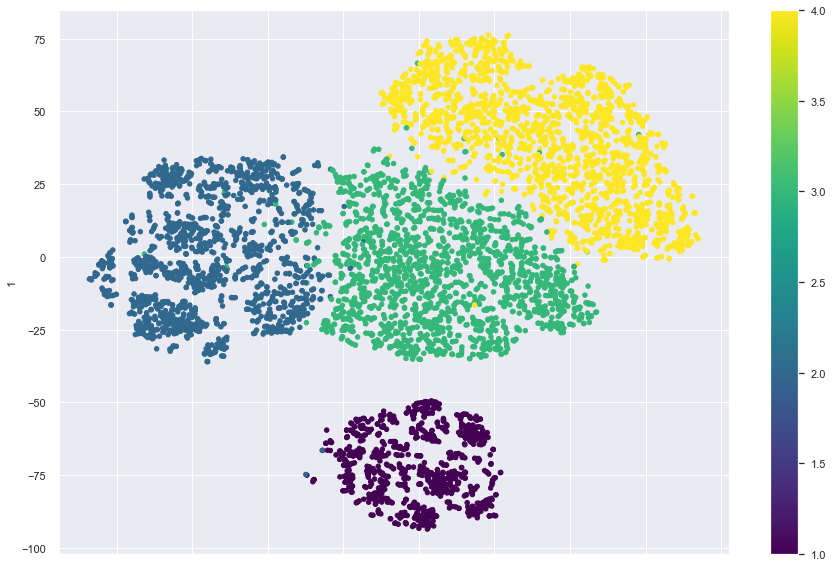

In [149]:
Tsne_hc = TSNE(perplexity=30, random_state=random_state).fit_transform(X_hc)

pd.DataFrame(Tsne_hc).plot.scatter(x=0, y=1, c = X_hc['hc_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

- As we can see the obtained clusters are well separated which is a good thing.

___

# **7. Density Based Clustering:**


## **7.1 Mean Shift Clustering:**

### _Characteristics:_
- No need to define number of clusters apriori.
- Can detect clusters of any shape.
- Robust to outliers.
- Depends on the bandwidth hyperparameter.
- **Main drawback**: Poor scalability (on both the algorithm and in estimating the bandwidth).

In [150]:
# The following bandwidth can be automatically detected using (we need to set a quantile).
# Based on distance to nearest neighbors for all observations.

bandwidth = estimate_bandwidth(X[num_vars], quantile=0.06, n_samples=50, 
                               random_state=random_state, n_jobs=-1)
bandwidth

2.4508017246004186

In [151]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(X[num_vars])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 2


In [152]:
# Concatenating the labels to X
X_ms = pd.concat([X, pd.Series(ms_labels, index=X.index, name="ms_labels")], axis=1)

In [153]:
# Concatenating the labels to X
X_beforeNorm_ms = pd.concat([X_beforeNorm, pd.Series(ms_labels, index=X_beforeNorm.index, name="ms_labels")], axis=1)
X_beforeNorm_ms.groupby('ms_labels').mean().T

ms_labels                      0            1
EducDeg_High School     0.356386     0.323686
EducDeg_Basic           0.077245     0.078842
EducDeg_BScMSc          0.498606     0.528277
EducDeg_PhD             0.067764     0.069195
MonthSal             2572.916062  2506.448769
GeoLivArea_1.0          0.287786     0.307718
GeoLivArea_4.0          0.418572     0.393546
GeoLivArea_3.0          0.193809     0.204591
GeoLivArea_2.0          0.099833     0.094145
Children_1.0            0.727273     0.761810
Children_0.0            0.272727     0.238190
CustMonVal             42.229495   401.496524
ClaimsRate              0.910468     0.397685
PremMotor             314.481294   330.249647
PremHousehold         164.795873   163.775100
PremHealth            173.794328   163.438390
PremLife               34.254972    31.640988
PremWork               33.607044    31.405086
Age                    49.629950    48.352295
YearsAsCustomer        29.992471    29.923154

__Clusters Profilling:__

- __cluster 1__:
    - The mean of ages is equal to 49.
    - The highest claims rate.
    - The lowest customer monetary value.
- __cluster 2__:
    - The mean of ages is equal to 48.
    - The lowest claims rate.
    - The highest customer monetary value.

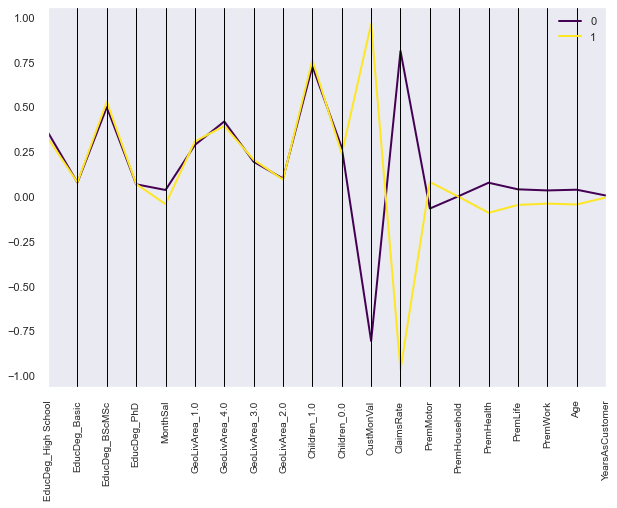

In [154]:
plt.figure(figsize=(10, 7))

# We need to define the centroids of our clusters.
centroids = X_ms.groupby('ms_labels', as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, class_column = "ms_labels", colormap="viridis",lw=2)

plt.xticks(fontsize=10, rotation=90)
plt.show();

**Clusters R²:**

In [155]:
r2_ms =  get_r2(X_ms[num_vars + ["ms_labels"]], "ms_labels")
print("Cluster solution with R^2 of %0.4f" % r2_ms);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_ms[num_vars + ['ms_labels']], 'ms_labels').drop('ms_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.1787


ClaimsRate         0.786602
CustMonVal         0.777977
PremHealth         0.006989
PremMotor          0.005454
PremLife           0.001881
Age                0.001686
MonthSal           0.001544
PremWork           0.001343
YearsAsCustomer    0.000027
PremHousehold      0.000011
dtype: float64

The R² of this clusters solution is not very high, the variables that contribute the most to the R² value are 'ClaimsRate' and 'CustMonVal'.

### Visualization of Mean shift clusters using TSNE:

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B75ACF10>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B75ACF10> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


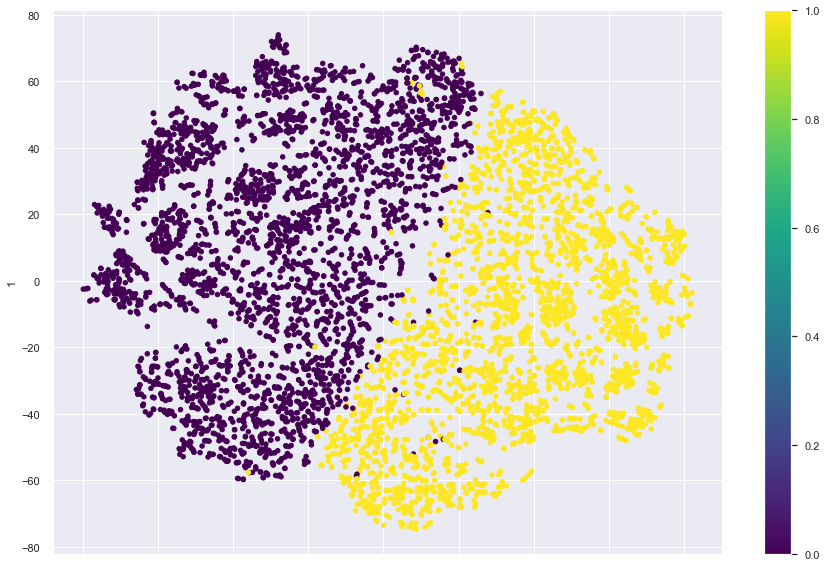

In [156]:
Tsne_ms = TSNE(perplexity=30, random_state=random_state).fit_transform(X_ms)

pd.DataFrame(Tsne_ms).plot.scatter(x=0, y=1, c = X_ms['ms_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

- As we can see the obtained clusters are well separated which is a good thing.

___

## **7.2 DBSCAN (Density-based spatial clustering of applications with noise):**

### Characteristics:
- No need to define number of clusters apriori.
- Resistant to noise and outliers.
- Can identify outliers.
- Can handle clusters of different shapes and sizes.
- Depends highly on the epsilon hyperparameter and it can be hard to tune.
- Does not work well with clusters of varying densities.

### Defining eps and min_samples:
- **MinPts**: As a rule of thumb, **minPts = 2 x dim** can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.

- **ε**: The value for ε can then be chosen by using a **k-distance graph**, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an **"elbow"**: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. **The assumption is that for points in a cluster, their k nearest neighbors are at roughly the same distance**. Noise points have their k-th nearest neighbors at farther distance

In [157]:
# Perform DBSCAN clustering.

dbscan = DBSCAN(eps=2.3, min_samples=15, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X[num_vars])
Counter(dbscan_labels)

Counter({0: 6589, -1: 3})

In [158]:
dbscan_n_clusters = len(np.unique(dbscan_labels)) - int(-1 in dbscan_labels)
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 1


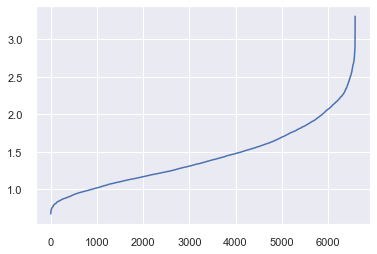

In [159]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(X[num_vars])
distances, _ = neigh.kneighbors(X[num_vars])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [160]:
# Concatenating the labels to X
X_dbscan = pd.concat([X, pd.Series(dbscan_labels, index=X.index, name="dbscan_labels")], axis=1)

In [161]:
# Concatenating the labels to X
X_beforeNorm_dbscan = pd.concat([X_beforeNorm, pd.Series(dbscan_labels, index=X_beforeNorm.index, name="dbscan_labels")], axis=1)
X_beforeNorm_dbscan.groupby('dbscan_labels').mean().T

dbscan_labels                 -1            0
EducDeg_High School     0.666667     0.341326
EducDeg_Basic           0.000000     0.078009
EducDeg_BScMSc          0.333333     0.512217
EducDeg_PhD             0.000000     0.068447
MonthSal             2193.000000  2542.765670
GeoLivArea_1.0          0.333333     0.296858
GeoLivArea_4.0          0.666667     0.407042
GeoLivArea_3.0          0.000000     0.198816
GeoLivArea_2.0          0.000000     0.097283
Children_1.0            0.333333     0.743208
Children_0.0            0.666667     0.256792
CustMonVal            418.423333   205.961185
ClaimsRate              0.363333     0.676778
PremMotor             244.416667   321.706952
PremHousehold         203.750000   164.312445
PremHealth             97.833333   169.104380
PremLife               93.016667    33.035679
PremWork              103.723333    32.570554
Age                    39.333333    49.051753
YearsAsCustomer        32.666667    29.959630

In [162]:
# Detecting noise (potential outliers)
X_dbscan.loc[X_dbscan['dbscan_labels'] == -1].head(2)

EducDeg_High School  EducDeg_Basic  EducDeg_BScMSc  EducDeg_PhD  \
5353                    1              0               0            0   
5377                    0              0               1            0   

      MonthSal  GeoLivArea_1.0  GeoLivArea_4.0  GeoLivArea_3.0  \
5353 -0.912333               0               1               0   
5377 -0.901651               0               1               0   

      GeoLivArea_2.0  Children_1.0  ...  CustMonVal  ClaimsRate  PremMotor  \
5353               0             0  ...    0.875895   -1.342648  -1.151067   
5377               0             0  ...    1.271371   -1.585733  -0.706952   

      PremHousehold  PremHealth  PremLife  PremWork       Age  \
5353      -1.089121    0.011963  3.185650  1.629100 -1.293398   
5377      -0.667028   -1.468680  3.544768  2.353299 -1.035329   

      YearsAsCustomer  dbscan_labels  
5353         1.523204             -1  
5377         0.005938             -1  

[2 rows x 21 columns]

__Clusters R²:__

In [163]:
r2_dbscan =  get_r2(X_dbscan, "dbscan_labels")
print("Cluster solution with R^2 of %0.4f" % r2_dbscan)

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_dbscan[num_vars + ['dbscan_labels']], 'dbscan_labels').drop('dbscan_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.0006


PremWork           0.002572
PremLife           0.001816
PremHealth         0.000607
ClaimsRate         0.000539
CustMonVal         0.000499
PremMotor          0.000240
Age                0.000179
MonthSal           0.000078
YearsAsCustomer    0.000077
PremHousehold      0.000031
dtype: float64

The R² of this clusters solution is very low.

- The DBSCAN clustering algorithm gave us just one cluster.
- Some observations are considered as noise.

___

## **7.3 GMM (Gaussian Mixture Model):**
 
$$\mathcal{p(\vec{x})} \ = \ \sum_{i=1}^K \phi_i \mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \tag{eq1}$$
$$\mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \ = \ \frac{1}{\sqrt{{(2\pi)}^{K}|\Sigma_i|}}e^{-\frac{1}{2} (\vec{x} - \vec{\mu_i})^T \Sigma_i^{-1} (\vec{x} - \vec{\mu_i})} \tag{eq2}$$
$$\sum_{i=1}^K \phi_i \ = \ 1 \tag{eq3}$$

, where:
- $\phi_i$ is the component weight (scalar) for Component $i$ (probability of an observation being generated by Component $i$)
- $\vec{\mu_i}$ is the mean vector for Component $i$,
- $\Sigma_i$ is the Covariance matrix for Component $i$

---

- **(eq1)** gives the probability of a point $x$ given the estimated Gaussian mixture
- **(eq2)** is the probability density function of a multivariate Gaussian with mean $\vec{\mu_i}$ and covariance $\Sigma_i$
- **(eq3)** states that the sum of the component weights is 1, such that the total probability distribution normalizes to 1

### Characteristics:
- Assumes the data is generated from a mixture of finite number of Gaussian distributions with unknown parameters.
- Uses the EM (Expectation Maximization algorithm) to estimate the parameters.
- Provides a probability of each observation belonging to each cluster.
- Advantages over K-Means:
    - Can deal with spherical and elipsoid cluster shapes.
    - Number of components needs to be defined apriori.

In [164]:
# Performing GMM clustering:
n_components=3
gmm = GaussianMixture(n_components=n_components, covariance_type='tied', n_init=20,
                      init_params='kmeans', random_state=random_state)
gmm_labels = gmm.fit_predict(X[num_vars])
labels_proba = gmm.predict_proba(X[num_vars])

**Let's look at the estimated parameters:**

In [165]:
# The estimated component weights.
gmm.weights_

array([0.30899, 0.43347, 0.25754])

In [166]:
# The estimated mean vectors of the Components.
gmm.means_

array([[ 0.04921, -1.02513,  1.0052 ,  0.54029, -0.55742, -0.31015,
        -0.39424, -0.35713,  0.03929, -0.00169],
       [-0.03696,  0.12601,  0.02306, -0.76408,  0.77716,  0.46998,
         0.52555,  0.49917, -0.02273,  0.01055],
       [ 0.00316,  1.01784, -1.24483,  0.63781, -0.63927, -0.41892,
        -0.41157, -0.41169, -0.00888, -0.01573]])

In [167]:
# The estimated covariance matrices of the Components.
gmm.covariances_

array([[ 0.99866, -0.00114, -0.00376,  0.06703, -0.03275, -0.05299,
        -0.0415 , -0.0529 ,  0.90664, -0.01499],
       [-0.00114,  0.40159, -0.32647,  0.07043,  0.07026, -0.10233,
        -0.0507 , -0.02755, -0.00877, -0.00669],
       [-0.00376, -0.32647,  0.28848, -0.09827,  0.01841,  0.09746,
         0.06531,  0.04869,  0.00089,  0.00216],
       [ 0.06703,  0.07043, -0.09827,  0.55197, -0.16749, -0.50146,
        -0.34287, -0.34109,  0.07906,  0.02744],
       [-0.03275,  0.07026,  0.01841, -0.16749,  0.53694, -0.05317,
         0.08922,  0.10204, -0.04779, -0.01736],
       [-0.05299, -0.10233,  0.09746, -0.50146, -0.05317,  0.82934,
         0.05176,  0.04997, -0.05311, -0.02123],
       [-0.0415 , -0.0507 ,  0.06531, -0.34287,  0.08922,  0.05176,
         0.78862,  0.21331, -0.0591 , -0.01329],
       [-0.0529 , -0.02755,  0.04869, -0.34109,  0.10204,  0.04997,
         0.21331,  0.80893, -0.06482, -0.01774],
       [ 0.90664, -0.00877,  0.00089,  0.07906, -0.04779, -0.053

### __Defining covariance_type:__
This hyperparameter controls the **degrees of freedom** in the shape of each cluster The more degrees of freedom we have the more complex shapes the model can fit and the more computationally expensive the model will be.

- `covariance_type="tied"` makes all components share the same general covariance matrix.

### __Defining the number of clusters:__

- **AIC**: estimates the relative amount of information lost by a model used to represent the data-generation process. The smaller the better.

- **BIC**: similar to AIC but penalizes more complex models (i.e. favors simpler models). The smaller the better.

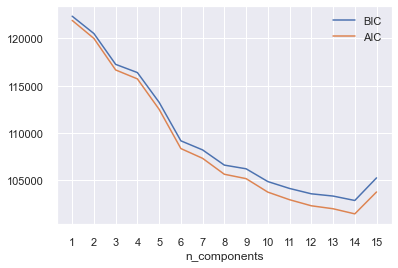

In [168]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n_components=n, covariance_type='tied', 
                          n_init=20, random_state=random_state).fit(X[num_vars])
          for n in n_components]

bic_values = [m.bic(X[num_vars]) for m in models]
aic_values = [m.aic(X[num_vars]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

**Note**: the AIC and BIC measures can also be used to select diferent hyperparameters such as the covariance_type

- The plot above shows that the best fit for the parameter n_components is 3.

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

For n_clusters = 2, the average silhouette_score is : 0.1614551616187489
For n_clusters = 3, the average silhouette_score is : 0.16319134900739496
For n_clusters = 4, the average silhouette_score is : 0.18549471284817584
For n_clusters = 5, the average silhouette_score is : 0.1506438990790614
For n_clusters = 6, the average silhouette_score is : 0.11962891414269576
For n_clusters = 7, the average silhouette_score is : 0.09509474055773029
For n_clusters = 8, the average silhouette_score is : 0.05893072878033095
For n_clusters = 9, the average silhouette_score is : 0.07259092418307432
For n_clusters = 10, the average silhouette_score is : 0.04318360772841518


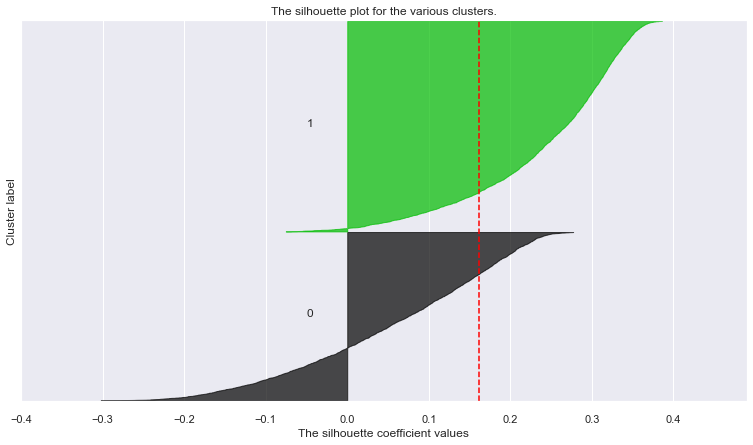

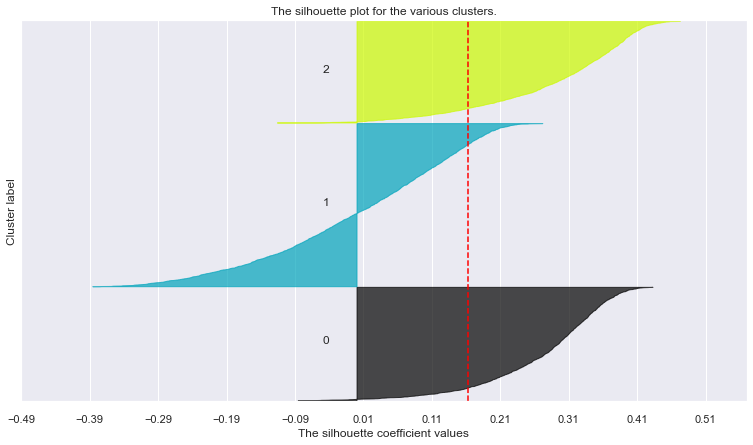

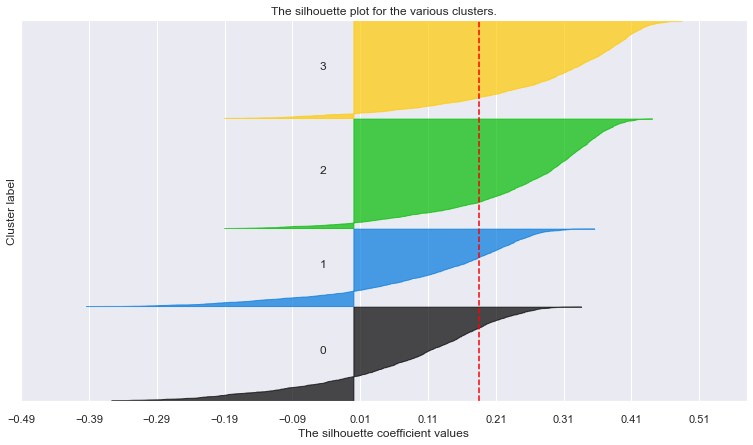

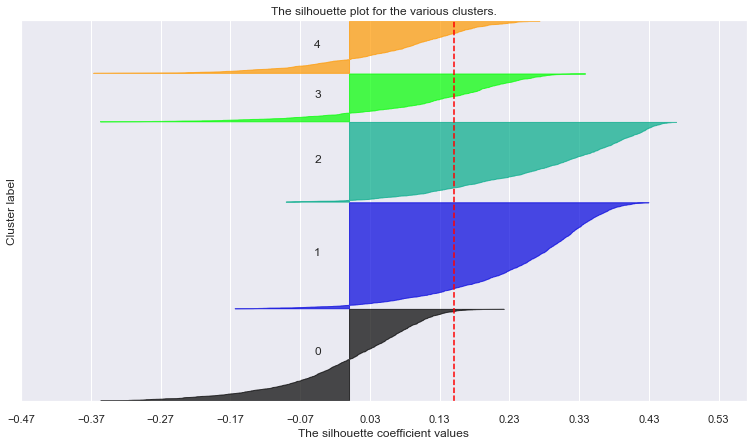

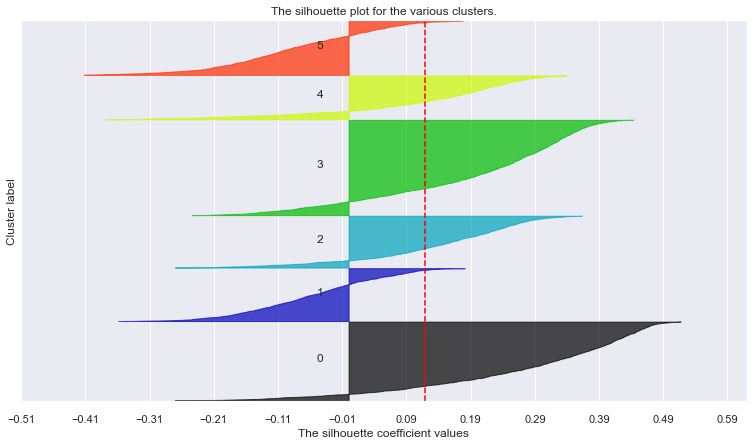

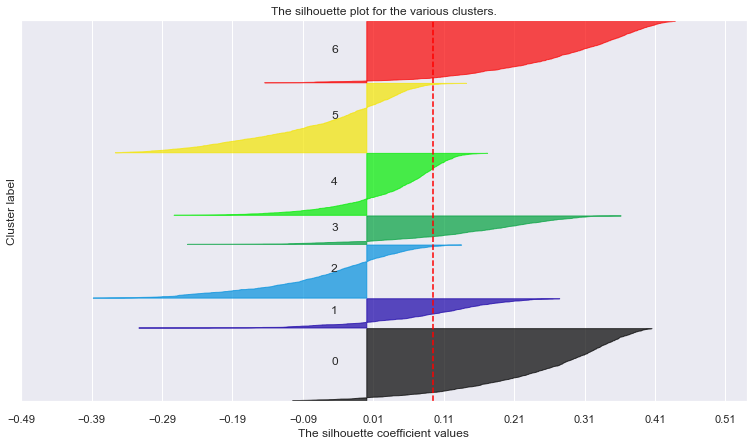

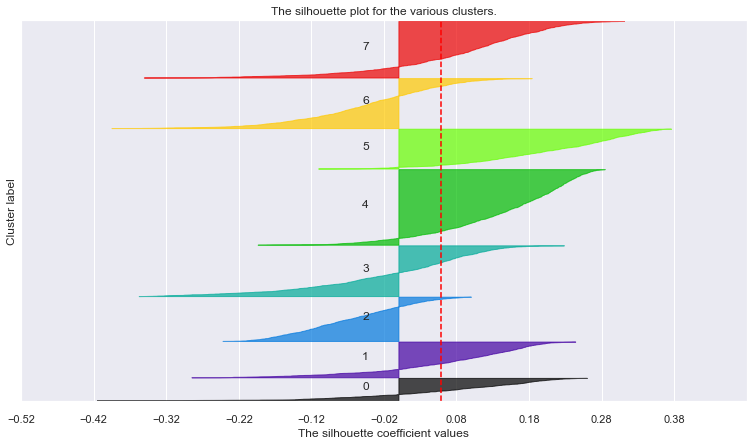

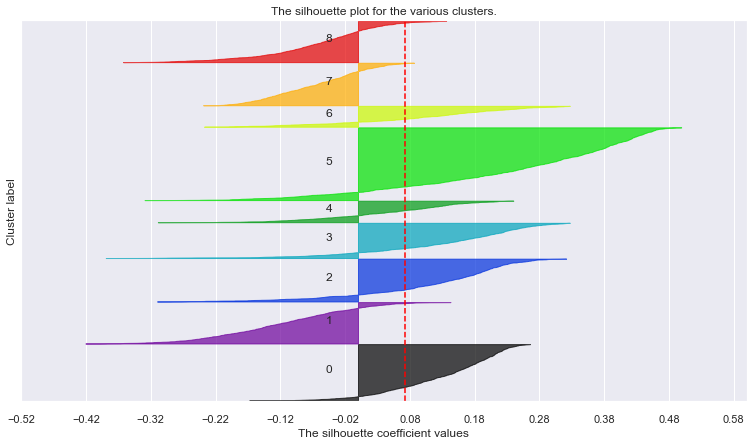

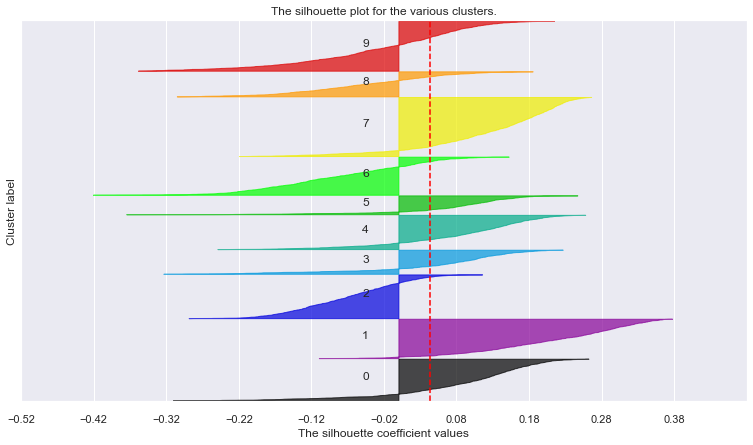

In [169]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.htmlsphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the gmm object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    gmmclust = GaussianMixture(n_components=nclus, covariance_type='full', n_init=20, 
                      init_params='kmeans', random_state=random_state)
    cluster_labels = gmmclust.fit_predict(X[num_vars])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X[num_vars], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X[num_vars], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X[num_vars]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

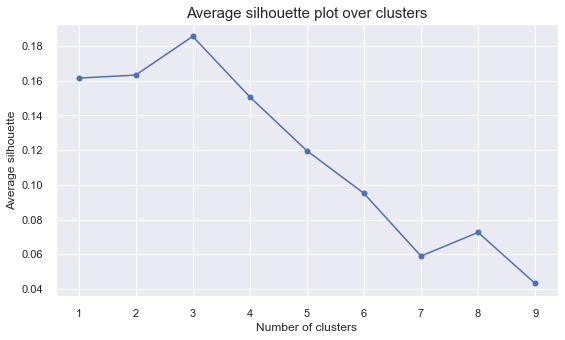

In [170]:
# The average silhouette plot
plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette, marker=".", markersize=12)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

The silhouette plot shows that the best number of clusters to choose is 3.

#### __Final Gaussian Mixture Model clustering solution:__

In [171]:
# Performing GMM clustering
n_components=3
gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=20, 
                      init_params='kmeans', random_state=random_state)
gmm_labels = gmm.fit_predict(X[num_vars])

In [172]:
# Concatenating the labels to X
X_gmm = pd.concat([X, pd.Series(gmm_labels, index=X.index, name="gmm_labels")], axis=1)

In [173]:
# Concatenating the labels to X
X_beforeNorm_gmm = pd.concat([X_beforeNorm, pd.Series(gmm_labels, 
                              index=X_beforeNorm.index, name="gmm_labels")], axis=1)
X_beforeNorm_gmm.groupby('gmm_labels').mean().T

gmm_labels                     0            1            2
EducDeg_High School     0.276682     0.444093     0.249012
EducDeg_Basic           0.046029     0.122363     0.042349
EducDeg_BScMSc          0.581184     0.404360     0.608131
EducDeg_PhD             0.096105     0.029184     0.100508
MonthSal             2579.175518  2515.495077  2545.321287
GeoLivArea_1.0          0.287304     0.295710     0.309430
GeoLivArea_4.0          0.411229     0.407525     0.402033
GeoLivArea_3.0          0.196763     0.200774     0.197628
GeoLivArea_2.0          0.104704     0.095992     0.090909
Children_1.0            0.792109     0.665612     0.812535
Children_0.0            0.207891     0.334388     0.187465
CustMonVal             -2.919762   223.612004   411.153783
ClaimsRate              0.967228     0.693066     0.325855
PremMotor             377.406227   240.991786   389.016155
PremHousehold          74.871902   282.887781    73.806522
PremHealth            155.785756   191.563899   147.784353
PremLife               19.694117    51.526396    18.336985
PremWork               20.678483    49.754406    18.371350
Age                    49.702074    48.672644    48.918125
YearsAsCustomer        29.981791    29.953235    29.949746

__Clusters Profiling:__

- __cluster 1__:
    - The mean of ages is equal to 50.
    - The highest claims rate.
    - The lowest customer monetary value.
    - A relatively low household premium.
- __cluster 2__:
    - The mean of ages is equal to 49.
    - A relatively high claims rate.
    - A relatively high customer monetary value.
- __cluster 3__:
    - The mean of ages is equal to 49.
    - The lowest claims rate.
    - The highest customer monetary value.

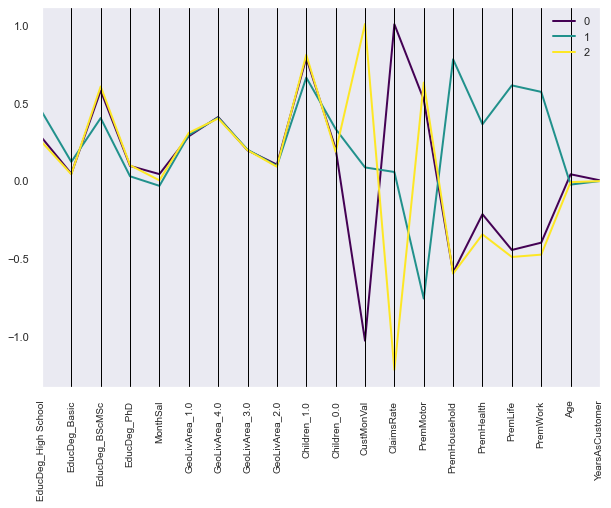

In [174]:
plt.figure(figsize=(10, 7))

# We need to define the centroids of our clusters.
centroids = X_gmm.groupby('gmm_labels', as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, class_column = "gmm_labels", colormap="viridis",lw=2)

plt.xticks(fontsize=10, rotation=90)
plt.show()

**Clusters R²:**

In [175]:
r2_gmm =  get_r2(X_gmm, "gmm_labels")
print("Cluster solution with R^2 of %0.4f" % r2_gmm);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_gmm[num_vars + ['gmm_labels']], 'gmm_labels').drop('gmm_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.2810


ClaimsRate         0.705463
CustMonVal         0.596060
PremHousehold      0.465380
PremMotor          0.438423
PremLife           0.287361
PremWork           0.250148
PremHealth         0.103232
MonthSal           0.001015
Age                0.000806
YearsAsCustomer    0.000004
dtype: float64

The R² of this clusters solution is not very high, the variables that contribute the most to the R² value are 'ClaimsRate' and 'CustMonVal'.

### Visualization of Gaussian Mixture Model clusters using TSNE:

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B57295E0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B57295E0> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


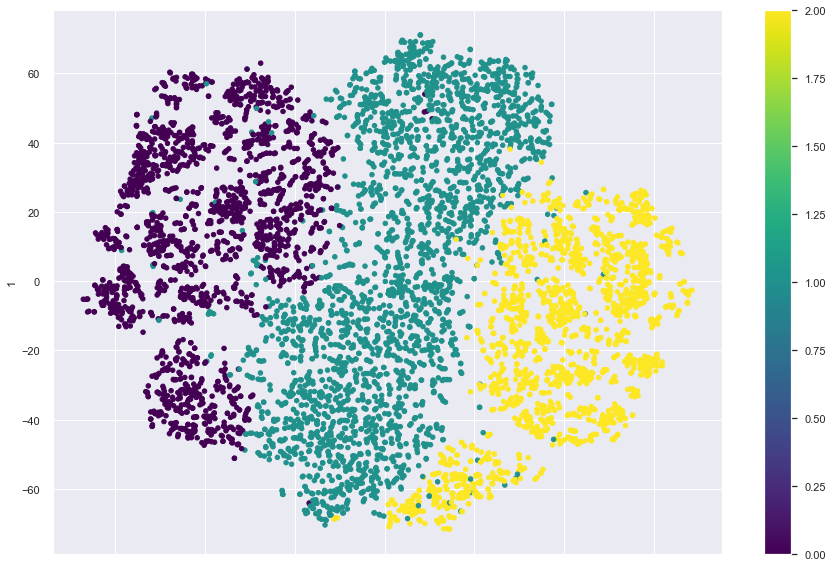

In [176]:
Tsne_gmm = TSNE(perplexity=30, random_state=random_state).fit_transform(X_gmm)
pd.DataFrame(Tsne_gmm).plot.scatter(x=0, y=1, c = X_gmm['gmm_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

- As we can see the obtained clusters are well separated which is a good thing.

___

# **8. Clustering by perspectives:**
We split the variables into perspectives.

In [177]:
# Split variables into perspectives (requires critical thinking and domain knowledge)
demographic_features = [
    'MonthSal',
    'Age',
    'YearsAsCustomer', 
    'CustMonVal',
    'ClaimsRate',  
]

Prem_features = [
    'PremMotor',
    'PremHousehold',
    'PremHealth',
    'PremLife',
    'PremWork', 
]

X_perspective = X.copy(deep=True)
X_dem = X_perspective[demographic_features].copy(deep=True)
X_prm = X_perspective[Prem_features].copy(deep=True)

## **Testing K-means and Hierarchical clustering:**

In [178]:
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = get_r2(df, labels)
    return r2_clust

In [179]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=random_state
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

### **Finding the optimal clusters on demographic variables:**

In [180]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(X_dem, kmeans)

for link in ['complete', 'average', 'single', 'ward']:
    r2_scores[link] = get_r2_scores(
        X_dem, hierarchical.set_params(linkage=link)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.314184  0.273228  0.292638  0.000160  0.268862
3  0.498096  0.434553  0.442054  0.000361  0.443504
4  0.602689  0.538137  0.557898  0.000634  0.554503
5  0.649842  0.576782  0.596132  0.000766  0.601489
6  0.689296  0.605088  0.643935  0.001179  0.641202
7  0.722433  0.643726  0.644051  0.001378  0.672889
8  0.752788  0.665284  0.679931  0.001546  0.701993
9  0.770698  0.699027  0.698027  0.001775  0.722473

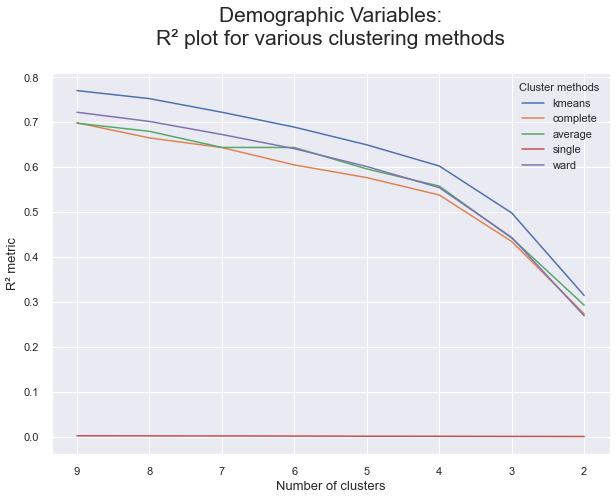

In [181]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.gca().invert_xaxis()  # invert x axis
plt.ylabel("R² metric", fontsize=13)
plt.show();

- Kmeans clustering performs better.

### **Repeat the process for premium variables:**

In [182]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(X_prm, kmeans)

for link in ['complete', 'average', 'single', 'ward']:
    r2_scores[link] = get_r2_scores(
        X_prm, hierarchical.set_params(linkage=link)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.402000  0.264858  0.338334  0.000638  0.363573
3  0.526147  0.313427  0.373376  0.001318  0.490924
4  0.576900  0.503157  0.420503  0.001547  0.533136
5  0.619301  0.533905  0.430462  0.001921  0.572421
6  0.653344  0.546019  0.458628  0.002326  0.602420
7  0.682296  0.559899  0.466775  0.003472  0.624394
8  0.703023  0.600095  0.479270  0.004159  0.645627
9  0.720205  0.607369  0.493634  0.004524  0.664505

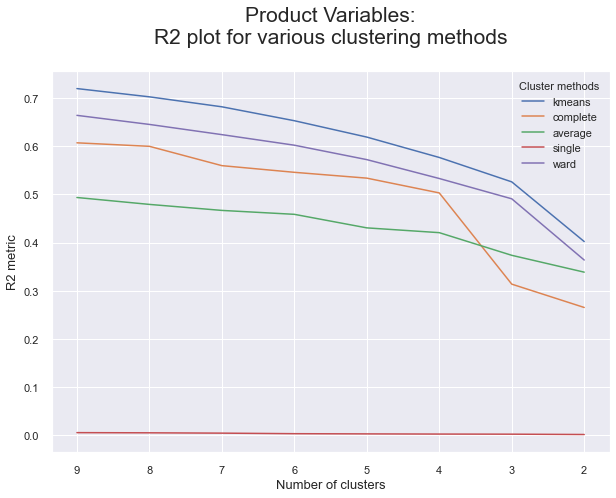

In [183]:
# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.gca().invert_xaxis()  # invert x axis
plt.ylabel("R2 metric", fontsize=13)
plt.show()

- Again Kmeans clustering performs better.

## **Merging the Perspectives:**
- How can we merge different cluster solutions?

In [184]:
# Applying the right clustering (algorithm and number of clusters) for each perspective

kmeans_dem = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=random_state
)
dem_labels = kmeans_dem.fit_predict(X_dem)


kmeans_prm = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=random_state
)

prm_labels = kmeans_prm.fit_predict(X_prm)

X_dem['dem_labels'] = dem_labels
X_prm['prm_labels'] = prm_labels

X_perspective["dem_labels"] = dem_labels
X_perspective["prm_labels"] = prm_labels

In [185]:
# Counting label frequencies (contigency table)
X_perspective.groupby(['prm_labels', 'dem_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('dem_labels', 'prm_labels', 0)

prm_labels    0    1    2
dem_labels               
0           630  436  660
1           648  334  558
2           705  384  653
3           644  334  606

### **Merging the clusters using Hierarchical clustering:**

In [186]:
# Centroids of the concatenated cluster labels
X_perspective_centroids = X_perspective.groupby(['dem_labels', 'prm_labels'])\
    [num_vars].mean()
X_perspective_centroids

MonthSal  CustMonVal  ClaimsRate  PremMotor  \
dem_labels prm_labels                                                
0          0          -0.586083   -1.000178    0.982978   1.016046   
           1          -1.135045   -0.679639    0.736560  -1.375519   
           2          -0.884567   -0.786603    0.772878  -0.365734   
1          0          -0.639260    1.084198   -1.326088   0.996177   
           1          -1.180030    1.079882   -0.662778  -1.315362   
           2          -0.934476    0.695211   -0.698217  -0.271118   
2          0           0.675415   -0.961777    0.948265   0.990800   
           1           0.933270   -0.704709    0.753239  -1.134526   
           2           0.979752   -0.795125    0.782367  -0.363310   
3          0           0.670173    1.127581   -1.311211   0.979945   
           1           0.943501    1.000415   -0.621918  -1.027631   
           2           0.918633    0.663368   -0.654709  -0.276200   

                       PremHousehold  PremHealth  PremLife  PremWork  \
dem_labels prm_labels                                                  
0          0               -0.624886   -0.817000 -0.641867 -0.644391   
           1                1.171250    0.560738  1.324432  1.226674   
           2               -0.195776    0.801878 -0.111788 -0.065219   
1          0               -0.624961   -0.817881 -0.622805 -0.622994   
           1                1.289644    0.434106  1.211047  1.239097   
           2               -0.080283    0.676906 -0.183103 -0.140784   
2          0               -0.519292   -0.905924 -0.575401 -0.543424   
           1                1.063044    0.374595  1.167937  1.042971   
           2               -0.108009    0.690073 -0.050217 -0.021285   
3          0               -0.493332   -0.938931 -0.504267 -0.515438   
           1                1.181584    0.164820  1.075021  1.101757   
           2               -0.028488    0.564533 -0.069941 -0.093980   

                            Age  YearsAsCustomer  
dem_labels prm_labels                             
0          0          -0.528510        -0.034522  
           1          -1.205352        -0.056353  
           2          -0.942170         0.036973  
1          0          -0.603123        -0.002491  
           1          -1.256696        -0.098090  
           2          -0.947687         0.081802  
2          0           0.640563         0.043386  
           1           0.969577         0.010285  
           2           1.049180         0.038003  
3          0           0.618976         0.004996  
           1           0.978226        -0.122620  
           2           0.965876        -0.018098

In [187]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(X_perspective_centroids)

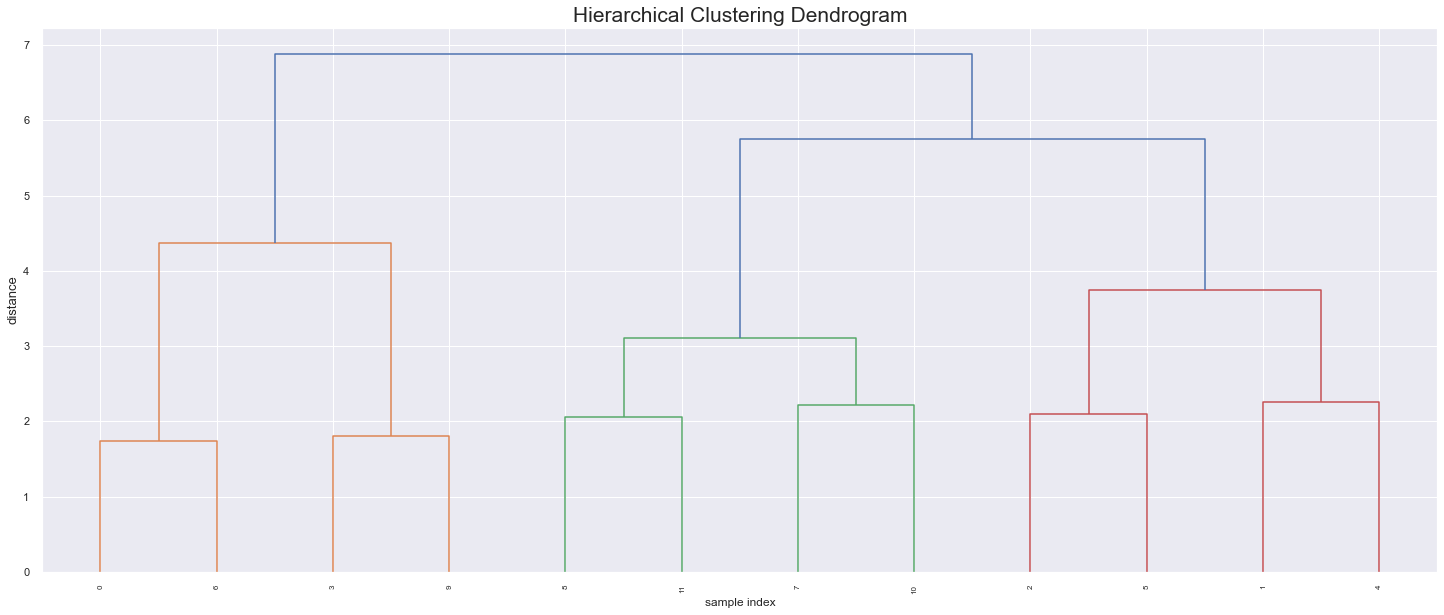

In [188]:
linked = linkage(X_perspective_centroids, method="ward", metric="euclidean")

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('sample index')
plt.ylabel('distance', fontsize=13)
dendrogram(
    linked,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

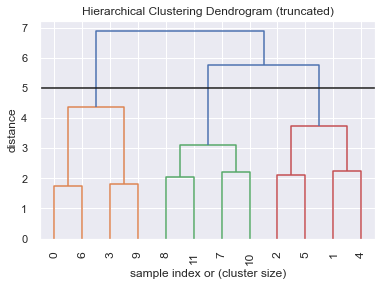

In [189]:
max_d = 5

fancy_dendrogram(
    linked,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [190]:
# Re-running the Hierarchical clustering based on the correct number of clusters

nclust=3

hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=nclust
)

hclust_labels = hclust.fit_predict(X_perspective_centroids)
X_perspective_centroids['hclust_labels'] = hclust_labels

X_perspective_centroids  # centroid's cluster labels

MonthSal  CustMonVal  ClaimsRate  PremMotor  \
dem_labels prm_labels                                                
0          0          -0.586083   -1.000178    0.982978   1.016046   
           1          -1.135045   -0.679639    0.736560  -1.375519   
           2          -0.884567   -0.786603    0.772878  -0.365734   
1          0          -0.639260    1.084198   -1.326088   0.996177   
           1          -1.180030    1.079882   -0.662778  -1.315362   
           2          -0.934476    0.695211   -0.698217  -0.271118   
2          0           0.675415   -0.961777    0.948265   0.990800   
           1           0.933270   -0.704709    0.753239  -1.134526   
           2           0.979752   -0.795125    0.782367  -0.363310   
3          0           0.670173    1.127581   -1.311211   0.979945   
           1           0.943501    1.000415   -0.621918  -1.027631   
           2           0.918633    0.663368   -0.654709  -0.276200   

                       PremHousehold  PremHealth  PremLife  PremWork  \
dem_labels prm_labels                                                  
0          0               -0.624886   -0.817000 -0.641867 -0.644391   
           1                1.171250    0.560738  1.324432  1.226674   
           2               -0.195776    0.801878 -0.111788 -0.065219   
1          0               -0.624961   -0.817881 -0.622805 -0.622994   
           1                1.289644    0.434106  1.211047  1.239097   
           2               -0.080283    0.676906 -0.183103 -0.140784   
2          0               -0.519292   -0.905924 -0.575401 -0.543424   
           1                1.063044    0.374595  1.167937  1.042971   
           2               -0.108009    0.690073 -0.050217 -0.021285   
3          0               -0.493332   -0.938931 -0.504267 -0.515438   
           1                1.181584    0.164820  1.075021  1.101757   
           2               -0.028488    0.564533 -0.069941 -0.093980   

                            Age  YearsAsCustomer  hclust_labels  
dem_labels prm_labels                                            
0          0          -0.528510        -0.034522              0  
           1          -1.205352        -0.056353              1  
           2          -0.942170         0.036973              1  
1          0          -0.603123        -0.002491              0  
           1          -1.256696        -0.098090              1  
           2          -0.947687         0.081802              1  
2          0           0.640563         0.043386              0  
           1           0.969577         0.010285              2  
           2           1.049180         0.038003              2  
3          0           0.618976         0.004996              0  
           1           0.978226        -0.122620              2  
           2           0.965876        -0.018098              2

In [191]:
X_ = X_perspective.copy()

# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = X_perspective_centroids['hclust_labels'].to_dict()

# Mapping the hierarchical clusters on the centroids to the observations
X_['merged_labels'] = X_.apply(
    lambda row: cluster_mapper[
        (row['dem_labels'], row['prm_labels'])
    ], axis=1
)

In [192]:
X_beforeNorm_merged = X_beforeNorm.copy(deep=True)
X_beforeNorm_merged['merged_labels'] = X_['merged_labels']

In [193]:
# Merged cluster centroids:

X_beforeNorm_merged.groupby('merged_labels').mean().T

merged_labels                  0            1            2
EducDeg_High School     0.261134     0.400402     0.388973
EducDeg_Basic           0.044157     0.111167     0.089530
EducDeg_BScMSc          0.591169     0.444165     0.475468
EducDeg_PhD             0.103540     0.044266     0.046029
MonthSal             2582.464408  1697.490946  3339.461811
GeoLivArea_1.0          0.304149     0.309859     0.274153
GeoLivArea_4.0          0.393605     0.396378     0.436014
GeoLivArea_3.0          0.203274     0.197183     0.194234
GeoLivArea_2.0          0.098972     0.096579     0.095599
Children_1.0            0.861058     0.905936     0.422357
Children_0.0            0.138942     0.094064     0.577643
CustMonVal            215.367899   199.233763   200.548978
ClaimsRate              0.631043     0.708541     0.705134
PremMotor             427.541663   245.082857   258.008948
PremHousehold          78.899315   222.768511   219.086318
PremHealth            115.336250   209.305619   200.017380
PremLife               15.484537    45.233129    44.183005
PremWork               15.235668    45.051952    43.161947
Age                    49.793300    32.706237    64.488113
YearsAsCustomer        29.987057    30.003018    29.883662

__Clusters Profiling:__

- __cluster 1__: 
    - The mean of ages is equal to 50.
    - The lowest claims rate.
    - The highest customer monetary value.
    - The highest motor premium value.
    - The second highest average monthly salary.
- __cluster 2__:
    - The yougest observations, the mean of ages is equal to 33.
    - A relatively high claims rate.
    - A relatively high customer monetary value.
    - Most of observations have children.
    - The lowest average monthly salary.
- __cluster 3__:
    - The oldest observations, the mean of ages is equal to 64.
    - A relatively high claims rate.
    - A relatively high customer monetary value.
    - Most of observations don't have children.
    - The highest average monthly salary.

## **Cluster Analysis:**

In [194]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction',
                        fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

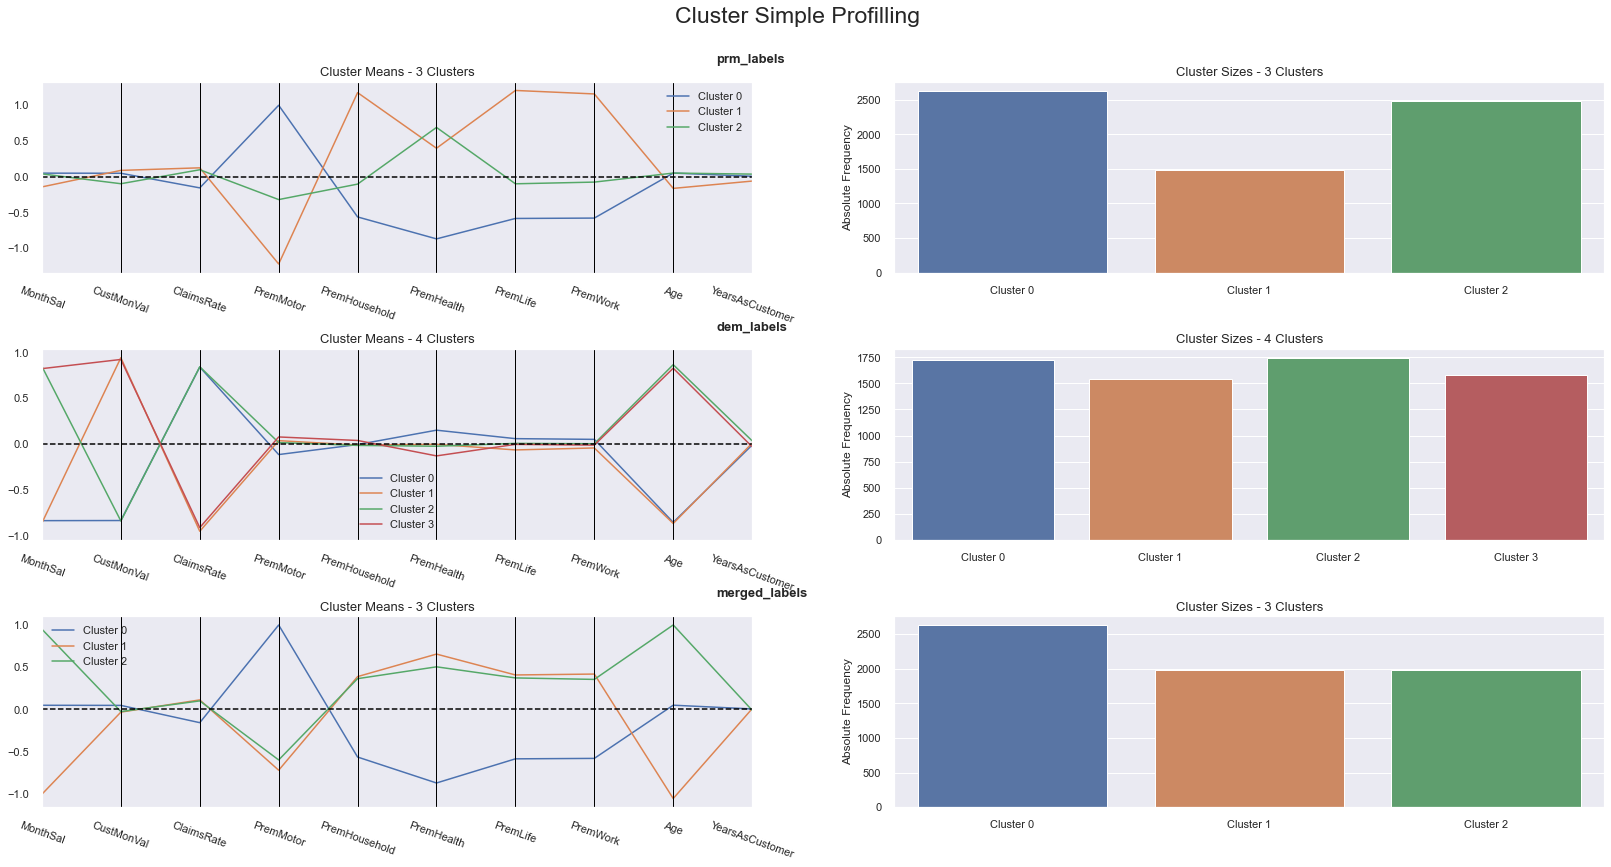

In [195]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = X_[num_vars + ['prm_labels', 'dem_labels', 'merged_labels']], 
    label_columns = ['prm_labels', 'dem_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["prm_labels", "dem_labels", "merged_labels"]
)

**Clusters R²:**

What proportion of each variables total SS is explained between clusters?

In [196]:
r2_merged =  get_r2(X_, "merged_labels")
print("Cluster solution with R^2 of %0.4f" % r2_merged);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_[num_vars + ['merged_labels']], 'merged_labels').drop('merged_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.3534


PremMotor          0.658845
Age                0.633761
MonthSal           0.572689
PremHealth         0.506012
PremLife           0.227386
PremWork           0.223792
PremHousehold      0.211079
ClaimsRate         0.016629
CustMonVal         0.001402
YearsAsCustomer    0.000060
dtype: float64

The R² of this clusters solution is not very high, the variables that contribute the most to the R² value are 'PremMotor' and 'Age'.

## __Clusters visualization using t-SNE:__

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B6443E80>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000299B6443E80> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


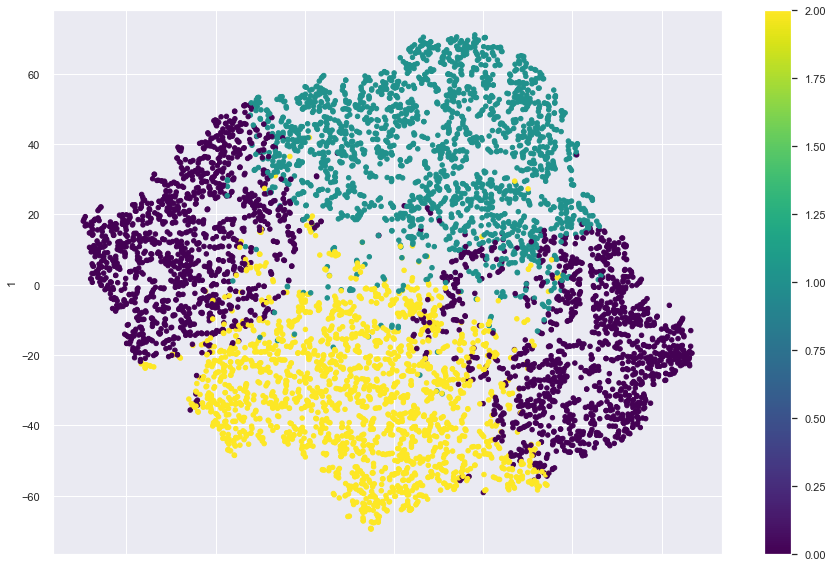

In [197]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=random_state).fit_transform(X_[num_vars])

# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=X_['merged_labels'], colormap='viridis', figsize=(15,10))
plt.show()

- As we can see the obtained clusters are not well separated and are kind of overlapping.

## **Assess feature importance:**


### **Using a Decision Tree:**
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [198]:
# Preparing the data
X_tree = X_.drop(columns=['prm_labels','dem_labels','merged_labels'])
y = X_["merged_labels"]

# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y, test_size=0.2, random_state=random_state
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=random_state, max_depth=5)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 97.65% of the customers correctly


In [199]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(axis=0, ascending=False)

PremMotor              0.523082
Age                    0.436302
MonthSal               0.019387
PremHealth             0.015187
PremWork               0.003576
PremLife               0.001024
PremHousehold          0.000806
CustMonVal             0.000636
EducDeg_High School    0.000000
ClaimsRate             0.000000
Children_0.0           0.000000
EducDeg_Basic          0.000000
Children_1.0           0.000000
GeoLivArea_2.0         0.000000
GeoLivArea_3.0         0.000000
GeoLivArea_4.0         0.000000
GeoLivArea_1.0         0.000000
EducDeg_PhD            0.000000
EducDeg_BScMSc         0.000000
YearsAsCustomer        0.000000
dtype: float64

Just like the results obtained using R², we can see that the most important features are 'PremMotor' and 'Age'.

run [WindowsPath('dot'), '-Kdot', '-Tsvg']


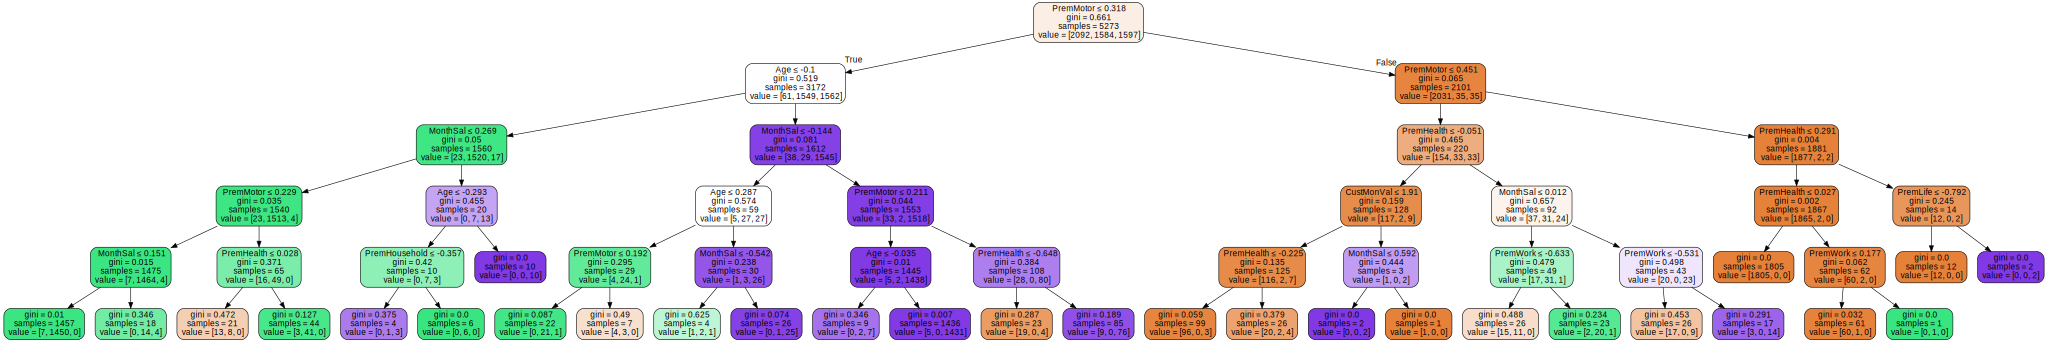

In [200]:
# Visualizing the decision tree

dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X_tree.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  

graphviz.Source(dot_data)

# **9. Self Organizing Map:**

A SOM is an artifcial neural network composed by a grid of output neurons
connected to an input layer.

This type of neural network uses an unsupervised learning algorithm to
fnd clusters in data without any privileged knowledge a priori.

The algorithm maps a multidimensional training set in a 2D grid of neurons
in a way that preserves the original topological relationships.

Inspired by: https://indico.lip.pt/event/396/contributions/898/attachments/995/1133/Franco_BigData.pdf

In [201]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(random_state)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    X[num_vars].values ,  
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=X.columns
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.837000, quantization error: 1.892866

 epoch: 2 ---> elapsed time:  1.699000, quantization error: 3.053107

 epoch: 3 ---> elapsed time:  1.063000, quantization error: 3.024845

 epoch: 4 ---> elapsed time:  0.780000, quantization error: 3.012312

 epoch: 5 ---> elapsed time:  0.701000, quantization error: 3.005988

 epoch: 6 ---> elapsed time:  0.687000, quantization error: 3.003182

 epoch: 7 ---> elapsed time:  0.940000, quantization error: 3.000595

 epoch: 8 ---> elapsed time:  0.786000, quantization error: 2.997454

 epoch: 9 ---> elapsed time:  0.854000, quantization error: 2.994781

 epoch: 10 ---> elapsed time:  0.807000, quantization error: 2.993175

 epoch: 11 ---> elapsed time:  0.860000, quantization error: 2.991910

 epoch: 12 ---> elapsed time:  0.869000, quantization error: 2.990718

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.740000, quantization error: 2.250842

 epoch: 15 ---> elapsed time:  0.741000, quantization error: 2.242755

 epoch: 16 ---> elapsed time:  0.726000, quantization error: 2.234664

 epoch: 17 ---> elapsed time:  0.620000, quantization error: 2.226623

 epoch: 18 ---> elapsed time:  0.674000, quantization error: 2.218581

 epoch: 19 ---> elapsed time:  0.727000, quantization error: 2.210501

 epoch: 20 ---> elapsed time:  0.789000, quantization error: 2.202396

 epoch: 21 ---> elapsed time:  0.693000, quantization error: 2.194212

 epoch: 22 ---> elapsed time:  0.676000, quantization error: 2.186027

 epoch: 23 ---> elapsed time:  0.649000, quantization error: 2.177801

 epoch: 24 ---> elapsed time:  0.707000, quantization error: 2.169519

 epoch: 25 ---> elapsed time:  0.678000, quantization error: 2.161173

 epoch: 26 ---> elapsed time:  0.576000, quantization error: 2.152755

 epoch: 27 ---> elapsed time:  0.593000, quantization error: 2.144266

 epoch

### __K-Means on top of SOM units:__

- We can visualize the clusters formed by labeled neurons:

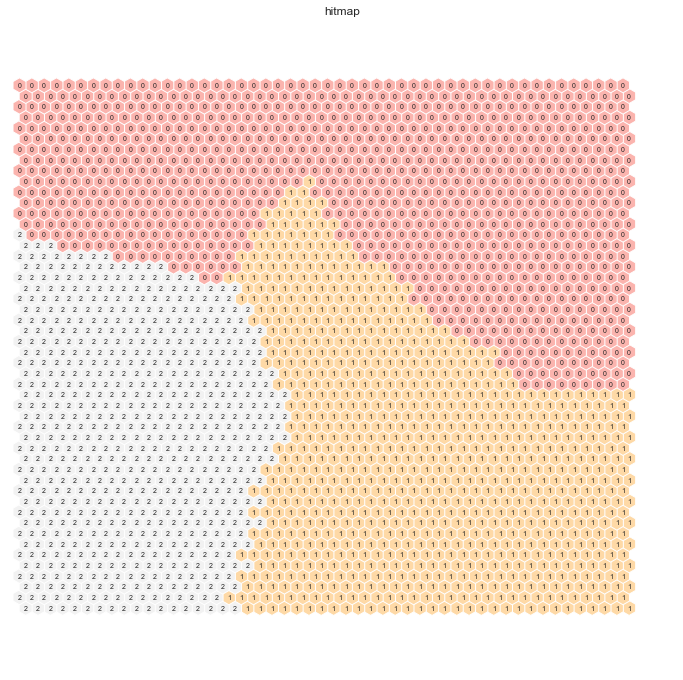

In [202]:
# Perform K-Means clustering on top of the 2500 units (sm.get_node_vectors() output)
nclus=3
kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=20, random_state=random_state)
nodeclus_labels_km = sm.cluster(kmeans)

hits  = HitMapView(12, 12, "hitmap", text_size=10) 
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

As we can see the cluster are well separated and do not overlap.

### __Hierarchical Clustering on top of SOM units:__

- We can visualize the clusters formed by labeled neurons:

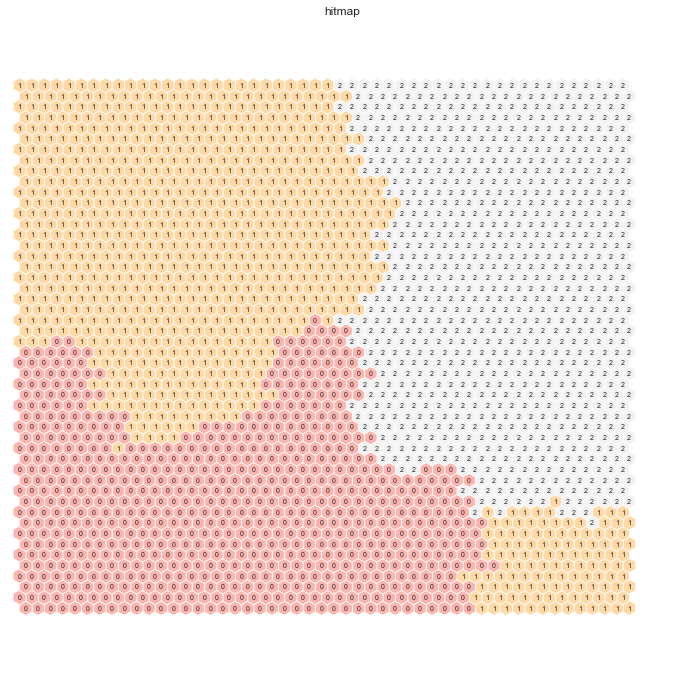

In [203]:
# Perform Hierarchical clustering on top of the 2500 units (sm.get_node_vectors() output)
nclus=3
hierclust = AgglomerativeClustering(n_clusters=nclus, linkage='ward')
nodeclus_labels_hc = sm.cluster(hierclust)

hits = HitMapView(12, 12, "hitmap", text_size=10) 
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

As we can see the cluster are well separated and do not overlap, but the first cluster is not compact.

### __Final SOM Clustering solution:__

In [204]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

df_nodes = pd.DataFrame(nodes, columns=X[num_vars].columns)
df_nodes['label'] = nodeclus_labels_km
df_nodes.head(2)

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0  1.193830   -1.049320    1.021622   0.110360      -0.667776    0.519789   
1  1.189217   -1.034344    1.007826  -0.039948      -0.457622    0.533609   

   PremLife  PremWork       Age  YearsAsCustomer  label  
0 -0.517239 -0.467261  1.372243        -0.914856      1  
1 -0.404803 -0.210650  1.302985        -0.928794      1

In [205]:
# Obtaining SOM's BMUs (Best Matching units) labels
df_bmus = pd.DataFrame(
    np.concatenate((X, np.expand_dims(sm._bmu[0],1)), axis=1),
    index=X.index, columns=np.append(X.columns,"BMU")
)
df_bmus.tail()

EducDeg_High School  EducDeg_Basic  EducDeg_BScMSc  EducDeg_PhD  \
10289                  1.0            0.0             0.0          0.0   
10291                  0.0            0.0             0.0          1.0   
10293                  0.0            0.0             1.0          0.0   
10294                  0.0            1.0             0.0          0.0   
10295                  0.0            0.0             0.0          1.0   

       MonthSal  GeoLivArea_1.0  GeoLivArea_4.0  GeoLivArea_3.0  \
10289  1.134049             0.0             1.0             0.0   
10291  0.766080             0.0             0.0             0.0   
10293  0.445591             1.0             0.0             0.0   
10294 -0.678495             0.0             0.0             0.0   
10295  0.323330             1.0             0.0             0.0   

       GeoLivArea_2.0  Children_1.0  ...  CustMonVal  ClaimsRate  PremMotor  \
10289             0.0           0.0  ...    0.194914   -0.023042  -0.882511   
10291             1.0           0.0  ...   -1.016260    0.984025   0.677675   
10293             0.0           1.0  ...    1.567719   -1.620460   0.770673   
10294             1.0           1.0  ...    0.216850   -0.092495  -1.251400   
10295             0.0           1.0  ...    1.270237   -1.412101   0.868937   

       PremHousehold  PremHealth  PremLife  PremWork       Age  \
10289       0.701966   -0.132130  2.234223  1.246447  1.545359   
10291      -0.758845    0.076797 -0.775632 -0.595633  1.158256   
10293      -0.208275   -0.434742 -0.679357 -0.926151 -0.583708   
10294       0.309268    0.474876  1.027283  2.683817 -0.648226   
10295      -0.461596   -0.450951 -0.871908 -0.658795 -0.906294   

       YearsAsCustomer     BMU  
10289         0.005938   923.0  
10291         0.309391  2080.0  
10293        -1.207874  1908.0  
10294         0.764571   833.0  
10295        -0.600968  1859.0  

[5 rows x 21 columns]

In [206]:
# Get cluster labels for each observation
X_som = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
X_som.head(2)

EducDeg_High School  EducDeg_Basic  EducDeg_BScMSc  EducDeg_PhD  MonthSal  \
0                  1.0            0.0             0.0          0.0 -0.433974   
2                  0.0            1.0             0.0          0.0 -0.315274   

   GeoLivArea_1.0  GeoLivArea_4.0  GeoLivArea_3.0  GeoLivArea_2.0  \
0             1.0             0.0             0.0             0.0   
2             0.0             0.0             1.0             0.0   

   Children_1.0  ...  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0           1.0  ...   -0.995383   0.509451      -0.560679   -0.368126   
2           0.0  ...   -1.377374  -1.086279       0.397451   -0.721146   

   PremLife  PremWork       Age  YearsAsCustomer     BMU  label  
0  0.464621 -0.525117 -0.970812         0.157665  2215.0      0  
2  1.775166  2.219621 -0.196605        -0.752694    28.0      1  

[2 rows x 22 columns]

In [207]:
X_beforeNorm_som = X_beforeNorm.copy(deep=True)
X_beforeNorm_som[["BMU", "label"]] = X_som[["BMU", "label"]]

In [208]:
# Characterizing the final clusters
X_beforeNorm_som.drop(columns='BMU').groupby('label').mean().T

label                          0            1            2
EducDeg_High School     0.260046     0.402459     0.422892
EducDeg_Basic           0.046717     0.098878     0.112048
EducDeg_BScMSc          0.593597     0.456975     0.424096
EducDeg_PhD             0.099641     0.041689     0.040964
MonthSal             2535.522052  3346.998931  1649.032530
GeoLivArea_1.0          0.301209     0.281133     0.306627
GeoLivArea_4.0          0.398236     0.427579     0.400602
GeoLivArea_3.0          0.202221     0.194014     0.197590
GeoLivArea_2.0          0.098334     0.097274     0.095181
Children_1.0            0.855603     0.412614     0.907831
Children_0.0            0.144397     0.587386     0.092169
CustMonVal            227.558190   197.842496   175.671440
ClaimsRate              0.614646     0.714388     0.748392
PremMotor             413.111715   254.639829   228.611012
PremHousehold          82.011320   232.063255   239.782500
PremHealth            127.479507   196.776066   214.541849
PremLife               16.131068    46.765735    48.840512
PremWork               16.269824    44.878071    48.885392
Age                    48.840575    64.570283    31.932530
YearsAsCustomer        30.008167    30.079102    29.740361

__Clusters Profiling:__

- __cluster 1__:
    - The mean of ages is equal to 49.
    - The lowest claims rate.
    - The highest customer monetary value.
    - Most observations have children.
    - The highest motor premium value.
- __cluster 2__:
    - The oldest observations, the mean of ages is equal to 65.
    - A relatively high claims rate.
    - A relatively high customer monetary value.
    - The highest average monthly salary.
- __cluster 3__:
    - The youngest observations, the mean of ages is equal to 32.
    - A relatively high claims rate.
    - A relatively high customer monetary value.
    - The lowest average monthly salary.

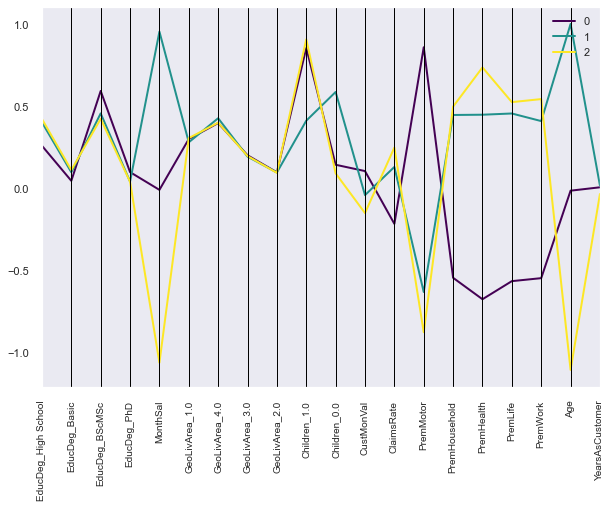

In [209]:
plt.figure(figsize=(10, 7))

# We need to define the centroids of our clusters.
centroids = X_som.drop(columns='BMU').groupby('label', as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, class_column = "label", colormap="viridis",lw=2)

plt.xticks(fontsize=10, rotation=90)
plt.show()

**Clusters R²:**

In [210]:
r2_som =  get_r2(X_som, "label")
print("Cluster solution with R^2 of %0.4f" % r2_som, "\n");

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_som[num_vars + ['label']], 'label').drop('label').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.6794 



PremMotor          0.648896
Age                0.591796
MonthSal           0.542092
PremHealth         0.405047
PremLife           0.276449
PremWork           0.260680
PremHousehold      0.256666
ClaimsRate         0.042033
CustMonVal         0.011331
YearsAsCustomer    0.000397
dtype: float64

The R² of this clusters solution is high, the variables that contribute the most to the R² value are 'ClaimsRate' and 'PremMotor'.

## __Clusters visualization using t-SNE:__

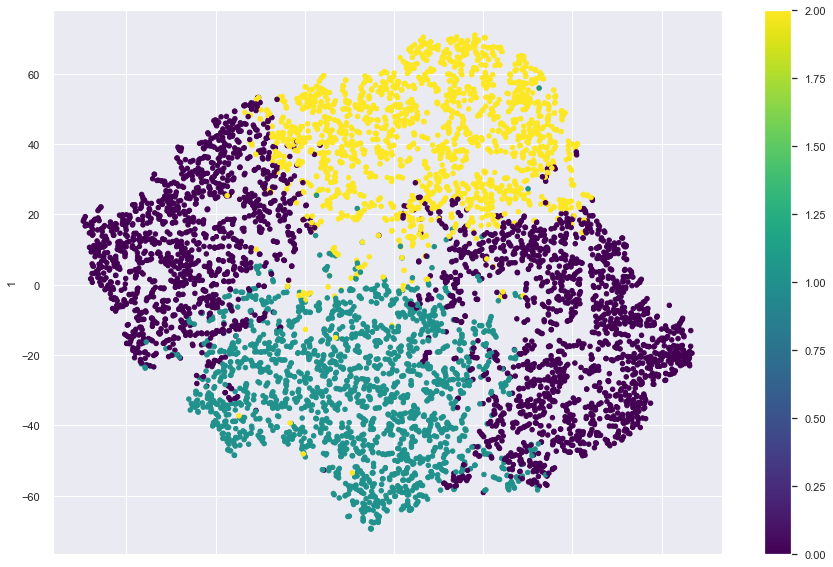

In [211]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=random_state).fit_transform(X_som[num_vars])

# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=X_som['label'], colormap='viridis', figsize=(15,10))
plt.show()

- As we can see the obtained clusters are well separated.

In [212]:
t2 = time.perf_counter()#
print('time taken to run:',(t2-t1)/60.0)

time taken to run: 28.156963251666664


___